In [ ]:
import torch
import time
import random
import argparse
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from scipy import stats
from tqdm import tqdm
from collections import OrderedDict
from torchsummary import summary
from torch.backends import cudnn
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from torch.utils.tensorboard import SummaryWriter
import pickle
import scipy.io

from google.colab import drive
import sys
drive.mount("/content/drive", force_remount=True)

main_path = '/content/drive/My Drive/PINN/' # ENZE marked: you need to change your main_path if it's not here
sys.path.append(main_path)
from cyclic_lr_scheduler import CyclicLR
from utils import draw_two_dimension, draw_two_dimension_different_x

Mounted at /content/drive


In [ ]:

class ConfigAD:
   def __init__(self):
        # print("--------------------------------------------------call init--------------------------------------------------")
       
        self.T_all = 10.0 #
        self.T = 10.0 # collocation point?
        self.T_unit = 0.05
        self.T_N = int(self.T / self.T_unit)
        self.N = int(self.T / self.T_unit)

        # self.NN = 10  # can be modified if too slow (20 / 50 / ...)
        # self.MM = 1  # must be 1 (fixed)
        self.Node = 40

        # parameters
        # Amyloid
        self.k_a = 2.1
        self.k_ta = 0.08
        self.k_mt = 0.718
        self.d_a = 0.06
        self.theta = 2
        # Tau
        self.k_t = 5
        self.k_at = 0.08
        self.k_ma = 0.7
        self.d_t = 0.06
        self.delta = 2
        # Neurodegeneration
        self.k_tn = 0.03566
        self.k_mtn = 0.08
        self.gamma = 3
        self.k_an = 0.05
        self.k_man = 5.022
        self.beta = 3
        self.k_atn = 0.03
        # Cognition
        self.k_r = 0.0846
        self.k_nc = 0.3596
        self.k_mn = 1.8944
        self.alpha = 2

        np.random.seed(0)

                  # self.u_0 = np.random.rand(self.NN, self.MM).reshape([self.NN * self.MM])
                  # self.v_0 = np.random.rand(self.NN, self.MM).reshape([self.NN * self.MM])
                  # self.y_0 = np.concatenate([self.u_0, self.v_0])
        # self.y_0 = np.random.rand(self.NN, self.MM).reshape([self.NN * self.MM])

        self.ub = self.T
        self.lb = 0.0

        self.only_truth_flag = False  # True means only using loss_1 for truth_rate = 1.00, no other loss
        self.truth_rate = 0.1 #0.0034 # 0.0034 * 300 = 1 point(s) as truth #1.00 #0.25 #0.0005
        self.truth_length = int(self.truth_rate * self.T / self.T_unit)
        if not self.only_truth_flag:
            print("self.truth_length: {} of {} all ".format(self.truth_length, self.T_N))

        self.continue_period = 0.2
        self.round_bit = 3
        self.continue_id = None
        self.mapping_overall_flag = False
        self.loss2_partial_flag = False


In [ ]:
def block_design_a(network_unit, sig):
    # print("--------------------------------------------------call block design a--------------------------------------------------")
    return nn.Sequential((OrderedDict({
      'lin1': nn.Linear(1, network_unit),
      'sig1': sig,
      'lin2': nn.Linear(network_unit, network_unit),
      'sig2': sig,
      'lin3': nn.Linear(network_unit, network_unit),
      'sig3': sig,
      'lin4': nn.Linear(network_unit, 1),
    })))

In [ ]:
from matplotlib import Parameter
mat = scipy.io.loadmat(main_path+'Data/20220822truth40.mat')
Laplacian = torch.Tensor(mat['avgNet']).float()
r = torch.Tensor(mat['r']).float().reshape([10])
traj = torch.Tensor(mat['YOUT'][-1,:]).reshape([1, -1]).float()
parameters = torch.Tensor(mat['parameters'])[0].float()

NameError: ignored

In [ ]:
print(parameters)


tensor([2.1000e+00, 8.0000e-02, 7.1800e-01, 6.0000e-02, 2.0000e+00, 5.0000e+00,
        8.0000e-02, 7.0000e-01, 6.0000e-02, 2.0000e+00, 5.5660e-04, 1.0000e-02,
        2.0000e+00, 5.0000e-04, 2.0000e-02, 2.0000e+00, 3.0000e-03, 6.4600e-03,
        3.5960e-03, 2.9440e-03, 3.0000e+00])


In [ ]:
# % Amyloid
k_a = parameters[0];
k_ta = parameters[1];
k_mt = parameters[2];
d_a = parameters[3];
theta = parameters[4];
# % Tau
k_t = parameters[5];
k_at = parameters[6];
k_ma = parameters[7];
d_t = parameters[8];
delta = parameters[9];
# % Neurodegeneration
k_tn = parameters[10];
k_mtn = parameters[11];
gamma = parameters[12];
k_an = parameters[13];
k_man = parameters[14];
beta = parameters[15];
k_atn = parameters[16];
# % Cognition
k_r = parameters[17];
k_nc = parameters[18];
k_mn = parameters[19];
alpha = parameters[20];

torch.Size([1, 40])


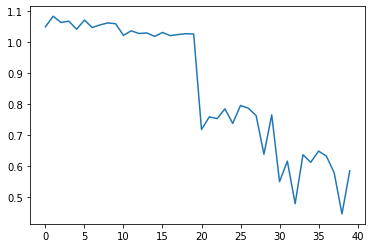

In [ ]:
A = traj[:, 0:10]
T = traj[:, 10:20]
N = traj[:, 20:30]
C = traj[:, 30:40]
print(traj.shape)
plt.plot(traj[0])
plt.show()

In [ ]:
# dy(A) = k_a*y(A).*(1 - y(A)) + (k_ta* y(T).^theta)./ (k_mt^theta + y(T).^theta) - d_a*Laplacian*y(A);  % x_a
# dy(T) = k_t*y(T).*(1 - y(T)) + (k_at* y(A).^delta)./ (k_ma^delta + y(A).^delta) - d_t*Laplacian*y(T); 
# dy(N) = (k_tn*y(T).^gamma)./ (k_mtn^gamma + y(T).^gamma) + (k_an*y(A).^beta)./ (k_man^beta + y(A).^beta) + k_atn*y(A).*y(T);
# dy(C) = - k_r*r + (k_nc*y(N).^alpha) ./ (k_mn^alpha + y(N).^alpha);

f_a = k_a*A*(1 - A) + (k_ta*torch.pow(T,theta)) / (np.power((k_mt),theta) + torch.pow(T,theta)) - d_a*torch.matmul(A,Laplacian)
f_t = k_t*T*(1 - T) + (k_at*torch.pow(A,delta)) / (np.power((k_ma),delta) + torch.pow(A,delta)) - d_t*torch.matmul(T,Laplacian)
f_n = (k_tn*torch.pow(T,gamma)) / (np.power((k_mtn),gamma) + torch.pow(T,gamma))+ (k_an*torch.pow(A,beta)) / (np.power((k_man),beta) + torch.pow(A,beta))+  k_atn*A*T
f_c = - k_r*r + (k_nc*torch.pow(N,alpha)) / (np.power((k_mn),alpha) + torch.pow(N,alpha))
    


In [ ]:
A

tensor([[0.5077, 0.4733, 0.4159, 0.4604, 0.3912, 0.5003, 0.4643, 0.4847, 0.4112,
         0.3834]])

In [ ]:
1 - A 

tensor([[0.4923, 0.5267, 0.5841, 0.5396, 0.6088, 0.4997, 0.5357, 0.5153, 0.5888,
         0.6166]])

In [ ]:
k_a*A*(1 - A) 


tensor([[0.5249, 0.5235, 0.5101, 0.5217, 0.5001, 0.5250, 0.5223, 0.5245, 0.5084,
         0.4964]])

In [ ]:
print(f_a, f_t, f_n, f_c)

tensor([[ 3.3528e-08,  7.4506e-08,  1.5646e-07,  1.1921e-07, -1.8626e-08,
         -9.6858e-08, -2.6077e-08,  2.9802e-08, -5.2154e-08, -2.2352e-08]]) tensor([[ 1.1921e-07, -1.6391e-07, -1.7881e-07,  2.4587e-07, -2.8685e-07,
          2.5332e-07, -1.3411e-07,  1.4901e-08, -2.3097e-07,  6.7055e-08]]) tensor([[0.0043, 0.0044, 0.0043, 0.0043, 0.0042, 0.0044, 0.0043, 0.0043, 0.0043,
         0.0043]]) tensor([[-0.0024, -0.0021, -0.0024, -0.0024, -0.0022, -0.0025, -0.0023, -0.0023,
         -0.0022, -0.0020]])


In [ ]:
class SimpleNetworkAD(nn.Module):
  def __init__(self, config):
        # print("--------------------------------------------------call init of SimpleNetwork AD--------------------------------------------------")
        super(SimpleNetworkAD, self).__init__()
        self.setup_seed(0)
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.x, self.y0, self.t0 = None, None, None
        self.generate_x()
        # self.optimizer = optim.LBFGS(self.parameters(), lr=0.001, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
        self.initial_start()
        self.model_name = "SimpleNetworkAD"
        self.gt = GroundTruthAD(self.config.T, self.config.T_N)
        self.gt_data = torch.Tensor(self.gt.data).to(self.device)
        # self.gt_v = torch.Tensor(self.gt.v).to(self.device)

        self.sig = nn.Tanh()
        self.network_unit = 20

        # Design A
        A_blocks = [block_design_a(self.network_unit, self.sig) for i in range(self.config.Node//4)]
        T_blocks = [block_design_a(self.network_unit, self.sig) for i in range(self.config.Node//4)]
        N_blocks = [block_design_a(self.network_unit, self.sig) for i in range(self.config.Node//4)]
        C_blocks = [block_design_a(self.network_unit, self.sig) for i in range(self.config.Node//4)]

        self.sequences_A = nn.Sequential(*A_blocks)
        self.sequences_T = nn.Sequential(*T_blocks)
        self.sequences_N = nn.Sequential(*N_blocks)
        self.sequences_C = nn.Sequential(*C_blocks)


  def forward(self, inputs):
      # print("--------------------------------------------------call forward--------------------------------------------------")
      # print("call forward",inputs.shape)
      # A_input = inputs[:, :self.config.NN * self.config.MM]

      # A_input = inputs[:, 0:160]
      # T_input = inputs[:, 160:320]
      # N_input = inputs[:, 320:480]
      # C_input = inputs[:, 480:640]

      A_input = inputs[:, 0:10]
      T_input = inputs[:, 10:20]
      N_input = inputs[:, 20:30]
      C_input = inputs[:, 30:40]
      
      A_output = [] 
      T_output = []
      N_output = [] 
      C_output = []

      # print("A_input", A_input.shape)
      # print("T_input", T_input.shape)
      # print("N_input", N_input.shape)
      # print("C_input", C_input.shape)
      

      # Design A  
      for i in range(self.config.Node//4):
        # print(i,A_input[:,i:i+1].shape)
        A_output.append(self.sequences_A[i](A_input[:,i:i+1]))
        T_output.append(self.sequences_T[i](T_input[:,i:i+1]))
        N_output.append(self.sequences_N[i](N_input[:,i:i+1]))
        C_output.append(self.sequences_C[i](C_input[:,i:i+1]))

      A_output = torch.cat(tuple(item for item in A_output), 1)
      T_output = torch.cat(tuple(item for item in T_output), 1)
      N_output = torch.cat(tuple(item for item in N_output), 1)
      C_output = torch.cat(tuple(item for item in C_output), 1)
      
      # print("A_output", A_output.shape)
      # print("T_output", T_output.shape)
      # print("N_output", N_output.shape)
      # print("C_output", C_output.shape)

      outputs = torch.cat((A_output, T_output, N_output, C_output), 1)

      # print("outputs", outputs.shape)

      # print("forward outputs shape:",outputs.shape)
      return outputs
  
  def generate_x(self):
      # print("--------------------------------------------------call generate x--------------------------------------------------")
      x = [[i*self.config.T_unit for j in range(self.config.Node)] for i in range(self.config.N)]  # toy
      x = np.asarray(x)
      x = self.encode_t(x)
      print("continue_id = {}: [0, {}] is mapped to [{}, {}]".format(self.config.continue_id, self.config.T, len(x[0]), len(x[-1])))
      self.x = torch.Tensor(x).float().to(self.device)
      



  def initial_start(self):
      # print("--------------------------------------------------call initial start--------------------------------------------------")
      
      ######################################change t0
      # everything ending with 0 is for loss 1
      # WHY ALLL INPUT HAS TO BETWEEN -1/1
      # self.t0 = torch.Tensor(np.asarray(np.asarray([np.random.rand()] * (self.config.Node)).reshape([1, -1]))).float().to(self.device)
      # print("self.t0",self.t0.shape)

      mat = scipy.io.loadmat(main_path+'Data/20220724truth40.mat')
      self.t0 = torch.Tensor(np.asarray(np.asarray([np.random.rand()] * (self.config.Node)).reshape([1, -1]))).float().to(self.device)#
      #torch.Tensor(mat['pred'][0,:]).reshape([1, -1]).float().to(self.device)
      # torch.Tensor(np.asarray(np.asarray([-1] * (self.config.Node)).reshape([1, -1]))).float().to(self.device)
      # self.y0 = torch.Tensor(np.asarray([0.0, 0.0]).reshape([1, -1])).float().to(self.device)
      # self.y0 = torch.Tensor(mat['pred'][-1,0,:]).reshape([1, -1]).float().to(self.device)
      self.y0 = torch.Tensor(mat['YOUT'][0,:]).reshape([1, -1]).float().to(self.device)

      # print("self.y0",self.y0.shape)


  def encode_t(self, num):
    # if not self.config.mapping_overall_flag:
    #     return (num - self.config.lb) / (self.config.ub - self.config.lb) * 2.0 - 1.0
    return num / self.config.T_all * 2.0 

  def decode_t(self, num):
      # if not self.config.mapping_overall_flag:
      #     return self.config.lb + (num + 1.0) / 2.0 * (self.config.ub - self.config.lb)
      return (num ) / 2.0 * self.config.T_all

  def loss_only_ground_truth(self):
    # print("--------------------------------------------------call loss only ground truth--------------------------------------------------")
    self.eval()
    y = self.forward(self.x)
    self.loss_norm = torch.nn.MSELoss().to(self.device)
    # print(y.shape, self.gt_data.shape)
    loss = self.loss_norm(y, self.gt_data)


    A = y[:, 0:10]
    T = y[:, 10:20]
    N = y[:, 20:30]
    C = y[:, 30:40]


    A_t_collection, T_t_collection, N_t_collection, C_t_collection = [], [], [], []

    for ii in range(self.config.Node//4):
      # A_t_collection.append(torch.gradient(A[:,ii:ii+1].reshape([self.config.N]))[0].reshape([self.config.N,1]))  # u_t = y_t[:, 0:1]
      # T_t_collection.append(torch.gradient(T[:,ii:ii+1].reshape([self.config.N]))[0].reshape([self.config.N,1]))  # u_t = y_t[:, 0:1]
      # N_t_collection.append(torch.gradient(N[:,ii:ii+1].reshape([self.config.N]))[0].reshape([self.config.N,1]))  # u_t = y_t[:, 0:1]
      # C_t_collection.append(torch.gradient(C[:,ii:ii+1].reshape([self.config.N]))[0].reshape([self.config.N,1]))  # u_t = y_t[:, 0:1]
      A_t_collection.append(torch.gradient(A[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.encode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
      T_t_collection.append(torch.gradient(T[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.encode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
      N_t_collection.append(torch.gradient(N[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.encode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
      C_t_collection.append(torch.gradient(C[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.encode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]

    A_t = torch.cat(A_t_collection, 1)
    T_t = torch.cat(T_t_collection, 1)
    N_t = torch.cat(N_t_collection, 1)
    C_t = torch.cat(C_t_collection, 1) 


    # mat = scipy.io.loadmat(main_path+'Data/avgNetwork.mat')
    # Laplacian = torch.Tensor(mat['avgNetwork']).float().to(self.device)[0:10, 0:10]
    # resil = scipy.io.loadmat(main_path+'Data/20220710resilience.mat')
    # r = torch.Tensor(resil['r']).float().to(self.device)

    mat = scipy.io.loadmat(main_path+'Data/20220724truth40.mat')
    Laplacian = torch.Tensor(mat['avgNet']).float().to(self.device)[0:10, 0:10]
    resil = scipy.io.loadmat(main_path+'Data/20220724truth40.mat')
    r = torch.Tensor(resil['r']).float().to(self.device).reshape([10])

    # f_a = k_a*A*(1 - A) + (k_ta*torch.pow(T,theta)) / (np.power((k_mt),theta) + torch.pow(T,theta)) - d_a*torch.matmul(A,Laplacian)
    # f_t = k_t*T*(1 - T) + (k_at*torch.pow(A,delta)) / (np.power((k_ma),delta) + torch.pow(A,delta)) - d_t*torch.matmul(T,Laplacian)
    # f_n = (k_tn*torch.pow(T,gamma)) / (np.power((k_mtn),gamma) + torch.pow(T,gamma))+ (k_an*torch.pow(A,beta)) / (np.power((k_man),beta) + torch.pow(A,beta))+  k_atn*A*T
    # f_c = - k_r*r + (k_nc*torch.pow(N,alpha)) / (np.power((k_mn),alpha) + torch.pow(N,alpha))
        

    f_a = A_t - (self.config.k_a*A*(1 - A) + (self.config.k_ta*torch.pow(T,self.config.theta)) / (np.power((self.config.k_mt),self.config.theta) + torch.pow(T,self.config.theta)) - self.config.d_a*torch.matmul(A,Laplacian))
    # print("+++++", (self.config.k_a*A*(1 - A)).size(),((self.config.k_ta*torch.pow(T,self.config.theta)) / (np.power((self.config.k_mt),self.config.theta) + torch.pow(T,self.config.theta))).size(),(self.config.d_a*torch.matmul(A,Laplacian)).size )
    # print("+++++",torch.mean(A[0,:]),torch.mean(T[0,:]),torch.mean(N[0,:]),torch.mean(C[0,:]), A_t[0,:],(self.config.k_a*A*(1 - A) + (self.config.k_ta*torch.pow(T,self.config.theta)) / (np.power((self.config.k_mt),self.config.theta) + torch.pow(T,self.config.theta)) - self.config.d_a*torch.matmul(A,Laplacian))[0,:])

    f_t = T_t - (self.config.k_t*T*(1 - T) + (self.config.k_at*torch.pow(A,self.config.delta)) / (np.power((self.config.k_ma),self.config.delta) + torch.pow(A,self.config.delta)) - self.config.d_t*torch.matmul(T,Laplacian))
    f_n = N_t - ((self.config.k_tn*torch.pow(T,self.config.gamma)) / (np.power((self.config.k_mtn),self.config.gamma) + torch.pow(T,self.config.gamma))+ 
                 (self.config.k_an*torch.pow(A,self.config.beta)) / (np.power((self.config.k_man),self.config.beta) + torch.pow(A,self.config.beta))+ 
                 self.config.k_atn*A*T)
    f_c = C_t - (- self.config.k_r*r + (self.config.k_nc*torch.pow(N,self.config.alpha)) / (np.power((self.config.k_mn),self.config.alpha) + torch.pow(N,self.config.alpha)))
    # print(f_c.shape)



    f_a = k_a*A*(1 - A) + (k_ta*torch.pow(T,theta)) / (np.power((k_mt),theta) + torch.pow(T,theta)) - d_a*torch.matmul(A,Laplacian)
    f_t = k_t*T*(1 - T) + (k_at*torch.pow(A,delta)) / (np.power((k_ma),delta) + torch.pow(A,delta)) - d_t*torch.matmul(T,Laplacian)
    f_n = (k_tn*torch.pow(T,gamma)) / (np.power((k_mtn),gamma) + torch.pow(T,gamma))+ (k_an*torch.pow(A,beta)) / (np.power((k_man),beta) + torch.pow(A,beta))+  k_atn*A*T
    f_c = - k_r*r + (k_nc*torch.pow(N,alpha)) / (np.power((k_mn),alpha) + torch.pow(N,alpha))
        

    f_y = torch.cat((f_a, f_t, f_n, f_c), 1)
    zeros_2 = torch.Tensor([[0.0 for i in range(self.config.Node//4 )] for j in range( self.config.N )]).to(self.device)
    zeros_2D = torch.Tensor([[0.0 for i in range(self.config.Node )] for j in range( self.config.N )]).to(self.device)
    # print("============================== sum fa/t/n/c: ", self.loss_norm(f_a, zeros_2), self.loss_norm(f_t, zeros_2), self.loss_norm(f_n, zeros_2), self.loss_norm(f_c, zeros_2), "================================================")
    # print("============================== sum fy: ", self.loss_norm(f_y, zeros_2D), "================================================")

    loss_2 = self.loss_norm(f_y, zeros_2D)  # + torch.var(torch.square(f_y))


    self.train()



    return loss, [loss, loss_2], []
  

  def loss(self):
    # print("--------------------------------------------------call loss--------------------------------------------------")
    self.eval()
    # print("--------------------------------------------------called eval--------------------------------------------------")
    # for loop *271
    y = self.forward(self.x)
    # print('y', y.shape)

    # print("y0_pred input, t0",self.t0.shape)
    y0_pred = self.forward(self.t0)
    # print('y0_pred', y0_pred.shape)
    # print("y.shape:", y[:, 0:1].shape)
    # print(y[:, 0:1])
    # print("self.x.shape:", self.x[:, 0:1].shape)
    # y_t = torch.gradient(y, spacing=(self.x,))[0]  # y_t = tf.gradients(y, t)[0]
    # u = y[:, 0:1]
    # v = y[:, 1:2]

    # A = y[:, 0:160]
    # T = y[:, 160:320]
    # N = y[:, 320:480]
    # C = y[:, 480:640]

    A = y[:, 0:10]
    T = y[:, 10:20]
    N = y[:, 20:30]
    C = y[:, 30:40]

    # print("A", A.shape)
    # print("T", T.shape)
    # print("N", N.shape)
    # print("C", C.shape)

    A_t_collection, T_t_collection, N_t_collection, C_t_collection = [], [], [], []

    # print("--------------------------------------------------made to gradient--------------------------------------------------")
    # print("self.A.shape: ",A[:,0:1].size())
    # print(self.config.T_N)
    # print("torch.gradient(A[:,ii:ii+1].reshape([self.config.T_N])", torch.gradient(A[:,0:1].reshape([self.config.T_N])).size())
    # print("spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N])",self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]).size())
    # print("torch.gradient(A[:,ii:ii+1].reshape([self.config.T_N])", torch.gradient(A[:,0:1].reshape([self.config.T_N]))[0])
    # print("self.decode_t(self.x)[:, 0:1].shape: ",self.decode_t(self.x)[:, 0:1].shape)
    # print("self.config.T_N", self.config.T_N)
    # print("spacing: ",(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),).shape)

    for ii in range(self.config.Node//4):
      A_t_collection.append(torch.gradient(A[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
      T_t_collection.append(torch.gradient(T[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
      N_t_collection.append(torch.gradient(N[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
      C_t_collection.append(torch.gradient(C[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
      # print("A[:,ii:ii+1]", A[:,ii:ii+1].shape)
      # print("A[:,ii:ii+1].reshape([self.config.T_N])",A[:,ii:ii+1].reshape([self.config.N]).shape)
      # # print("torch.gradient(A[:,ii:ii+1].reshape([self.config.T_N]))",torch.gradient(A[:,ii:ii+1].reshape([self.config.N],-1)).shape)
      # print("torch.gradient(A[:,ii:ii+1].reshape([self.config.T_N]))[0]", torch.gradient(A[:,ii:ii+1].reshape([self.config.N]))[0].shape)

      ############################ add spacing
      # A_t_collection.append(torch.gradient(A[:,ii:ii+1].reshape([self.config.N]))[0].reshape([self.config.N,1]))  # u_t = y_t[:, 0:1]
      # T_t_collection.append(torch.gradient(T[:,ii:ii+1].reshape([self.config.N]))[0].reshape([self.config.N,1]))  # u_t = y_t[:, 0:1]
      # N_t_collection.append(torch.gradient(N[:,ii:ii+1].reshape([self.config.N]))[0].reshape([self.config.N,1]))  # u_t = y_t[:, 0:1]
      # C_t_collection.append(torch.gradient(C[:,ii:ii+1].reshape([self.config.N]))[0].reshape([self.config.N,1]))  # u_t = y_t[:, 0:1]


    A_t = torch.cat(A_t_collection, 1)
    T_t = torch.cat(T_t_collection, 1)
    N_t = torch.cat(N_t_collection, 1)
    C_t = torch.cat(C_t_collection, 1) 
    

    # print("--------------------------------------------------gradient before reshape--------------------------------------------------")

    # print("A_t", A_t.shape)
    # print("T_t", T_t.shape)
    # print("N_t", N_t.shape)
    # print("C_t", C_t.shape)

    # print("--------------------------------------------------gradient after reshape--------------------------------------------------")


    mat = scipy.io.loadmat(main_path+'Data/20220724truth40.mat')
    Laplacian = torch.Tensor(mat['avgNet']).float().to(self.device)[0:10, 0:10]
    resil = scipy.io.loadmat(main_path+'Data/20220724truth40.mat')
    r = torch.Tensor(resil['r']).float().to(self.device).reshape([10])
    
    f_a = A_t - (self.config.k_a*A*(1 - A) + (self.config.k_ta*torch.pow(T,self.config.theta)) / (np.power((self.config.k_mt),self.config.theta) + torch.pow(T,self.config.theta)) - self.config.d_a*torch.matmul(A,Laplacian))
    # print(f_a.shape)
    f_t = T_t - (self.config.k_t*T*(1 - T) + (self.config.k_at*torch.pow(A,self.config.delta)) / (np.power((self.config.k_ma),self.config.delta) + torch.pow(A,self.config.delta)) - self.config.d_t*torch.matmul(T,Laplacian))
    # print(f_t.shape)
    f_n = N_t - ((self.config.k_tn*torch.pow(T,self.config.gamma)) / (np.power((self.config.k_mtn),self.config.gamma) + torch.pow(T,self.config.gamma))+ 
                 (self.config.k_an*torch.pow(A,self.config.beta)) / (np.power((self.config.k_man),self.config.beta) + torch.pow(A,self.config.beta))+ 
                 self.config.k_atn*A*T)
    # print(f_n.shape)
    f_c = C_t - (- self.config.k_r*r + (self.config.k_nc*torch.pow(N,self.config.alpha)) / (np.power((self.config.k_mn),self.config.alpha) + torch.pow(N,self.config.alpha)))
    # print(f_c.shape)
    # print(5)
    # print("============================== sum fa/t/n/c: ", torch.mean(f_a), torch.mean(f_t), torch.mean(f_n), torch.mean(f_c), "================================================")
    f_y = torch.cat((f_a, f_t, f_n, f_c), 1)
  

    # print("--------------------------------------------------calculate gradient--------------------------------------------------")

    # L2 norm
    self.loss_norm = torch.nn.MSELoss().to(self.device)
    # print(1)
    zeros_1D = torch.Tensor([[0.0]] * self.config.N).to(self.device)
    # print(2)

    ##### match f_y. N*Node
    zeros_2D = torch.Tensor([[0.0 for i in range(self.config.Node )] for j in range( self.config.N )]).to(self.device)
    # print("###################################### zeros_2D", zeros_2D.shape)
    # print("============================== fy: ", torch.sum(f_y), f_y.size(),self.loss_norm(f_y, zeros_2D), "================================================")
    # print("============================== fy: ", y.size(), self.gt_data.size(), "================================================")

    # loss_1 = self.loss_norm(y0_pred, self.y0)
    # print(3)
    loss_1 = self.loss_norm(y[:self.config.truth_length, :], self.gt_data[:self.config.truth_length, 0:40])
    # print(4)



    # print("loss_1:", type(loss_1), loss_1.shape, loss_1)
    # self.loss_2_weight_numpy = generate_normal_distribution_weight_normal(self.config.N, 2, epoch_ratio)

    # self.loss_2_weight_numpy = generate_normal_distribution_weight(self.config.N, 2, (epoch % int(self.config.sliding_window_step)) / self.config.sliding_window_step)
    
    
    
    
    
    if self.config.loss2_partial_flag:
        new_period = int(self.config.continue_period * self.config.T_all / self.config.T_unit)
        loss_2 = self.loss_norm(f_y[-new_period:, :], zeros_2D[-new_period:, :])
    else:
        loss_2 = self.loss_norm(f_y, zeros_2D)  # + torch.var(torch.square(f_y))
        # print(5)


        
    # loss_2_details_normed = torch.abs(f_y * torch.Tensor(self.loss_2_weight_numpy).to(self.device)).cpu().detach().numpy()
    # loss_2_details_original = torch.abs(f_y).cpu().detach().numpy()
    # print("loss_2_details shape:", loss_2_details.shape)
    # loss_3 = self.loss_norm((0.1/(u * u + v * v + 1e-12)), zeros_1D) + self.loss_norm(torch.abs(u), u) + self.loss_norm(torch.abs(v), v)

    # loss 4 penalty for negative
    loss_3 = self.loss_norm(torch.abs(y[:self.config.truth_length, :]-0.3), y[:self.config.truth_length, :]-0.3)*1e5

    loss = (loss_1 + loss_2 + loss_3) # + loss_3)#+ loss_4 + loss_5) / 1e5
    # if loss < 2.0:
    #     f_y_square_pure = torch.square(f_y).cpu().detach().numpy()
    #     for i in range(20000):
    #         print(i, f_y_square_pure[i])
    self.train()
    return loss, [loss_1, loss_2, loss_3], []
    # return torch.mean(torch.square(y_hat - y))
    # return F.mse_loss(torch.cat((u_hat, v_hat), 1), torch.cat((u, v), 1))
    # return torch.abs(u_hat - u) + torch.abs(v_hat - v)  # F.mse_loss(x_hat, x) + beta * self.kl_div(rho)
  
  @staticmethod
  def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True
  

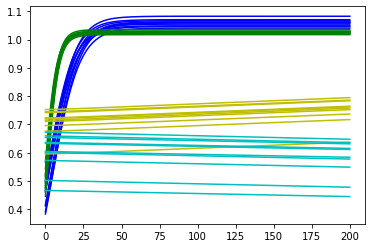

In [ ]:
mat = scipy.io.loadmat(main_path+'Data/20220822truth40.mat')
x = torch.Tensor(mat['YOUT']).float()
plt.plot(x[:,0:10], 'b')
plt.plot(x[:,10:20], 'g')
plt.plot(x[:,20:30], 'y')
plt.plot(x[:,30:40], 'c')
plt.show()




In [ ]:
class GroundTruthAD:
  def __init__(self, t_max, length):
    # print("--------------------------------------------------call init ground truth AD--------------------------------------------------")
    # U_start = 10.0
    # V_start = 5.0
    # alpha = 1.0
    # beta = 3.0
    # gamma = 0.3
    # e = 0.333
    # self.t = np.linspace(0, t_max, length)
    # # print(t)
    # y0 = np.asarray([U_start, V_start])
    # self.data = odeint(self.pend, y0, self.t, args=(alpha, beta, gamma, e))

    # with open(main_path+'Data/last_pt_YOUT.pkl', 'rb') as fin :
    #       x = pickle.load(fin)
    # self.data = torch.Tensor(x[1:,:]).float()



    mat = scipy.io.loadmat(main_path+'Data/20220822truth40.mat')
    self.data = torch.Tensor(mat['YOUT'][1:,:].reshape(200,-1)).float()
    print("----------------------------- ground truth ------------------------------------")

    plt.plot(self.data[:,0:10], 'b')
    plt.plot(self.data[:,10:20], 'g')
    plt.plot(self.data[:,20:30], 'y')
    plt.plot(self.data[:,30:40], 'c')
    plt.show()

    print("--------------------------------------------------------------------------")
    # print("HERERERERE Data ", self.data.shape)

    # mat = scipy.io.loadmat(main_path+'Data/last_pt.mat')
    # self.data = torch.Tensor(mat['pred']).float()
  
  # 
  # def pend(y, t, a, b, c, d):
  #   map = y
  #   dydt = np.asarray([(a * map[0]) - c * map[0] * map[1], - b * map[1] + d * c * map[0] * map[1]])
  #   return dydt

  # def print(self):
  #   plt.figure(figsize=(8, 6))
  #   plt.plot(self.t, self.data[:, 0], 'b', label='u')
  #   plt.plot(self.t, self.data[:, 1], 'r', label='v')
  #   plt.show()
  #   plt.clf()
  #   plt.close()

def get_now_string():
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(time.time()))


In [ ]:
def train_ad(model, args, config, now_string):
    # print("--------------------------------------------------call train AD--------------------------------------------------")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model.train()
    model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
    model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_best.pt"
    loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_loss_{args.epoch}.npy"
    board_save_path = f"{args.main_path}/board/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_board"
    print("using " + str(device))
    print("epoch = {}".format(args.epoch))
    print("epoch_step = {}".format(args.epoch_step))
    print("model_name = {}".format(model.model_name))
    print("now_string = {}".format(now_string))
    print("model_save_path_last = {}".format(model_save_path_last))
    print("model_save_path_best = {}".format(model_save_path_best))
    print("loss_save_path = {}".format(loss_save_path))
    print("args = {}".format({item[0]: item[1] for item in args.__dict__.items() if item[0][0] != "_"}))
    print("config = {}".format({item[0]: item[1] for item in config.__dict__.items() if item[0][0] != "_"}))
    print("ONLY TRUTH FLAG: ", )
    # gt = GroundTruthPP(config.T, config.N)
    writer = SummaryWriter(board_save_path)

    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    initial_lr = args.lr
    optimizer = optim.Adam(model.parameters(), lr = initial_lr)

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/10000+1)) # decade
    # scheduler = CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size=10000) # cyclic
    epoch_step = args.epoch_step
    start_time = time.time()
    start_time_0 = start_time
    best_loss = 999999
    now_time = 0
    loss_record = []
    
    for epoch in range(1, args.epoch + 1):
        # print("in epoch ", epoch)
        optimizer.zero_grad()
        inputs = model.x
        outputs = model(inputs)
        if config.only_truth_flag:
          # print("--------------------------------------------------loss only ground truth--------------------------------------------------")
          loss, loss_list, _ = model.loss_only_ground_truth()
        else:
          # print("--------------------------------------------------normal loss--------------------------------------------------")
          loss, loss_list, _ = model.loss()
        writer.add_scalar('Loss/train', loss.item(), epoch)
        
        # loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
        loss.backward()
        # print("loss backward")
        # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
        # _loss, _, lr, _, F_eval, G_eval, _, _ = optimizer.step(closure)
        optimizer.step()
        scheduler.step()
        loss_record.append(float(loss.item()))
        if epoch % epoch_step == 0:
            now_time = time.time()
            loss_print_part = " ".join(["Loss_{0:d}:{1:.6f}".format(i + 1, loss_part.item()) for i, loss_part in enumerate(loss_list)])
            # print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3: {5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0))
            print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} {3} Lr:{4:.6f} Time:{5:.6f}s ({6:.2f}min in total, {7:.2f}min remains)".format(epoch, args.epoch, loss.item(), loss_print_part, optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0, (now_time - start_time_0) / 60.0 / epoch * (args.epoch - epoch)))
            start_time = time.time()
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_last)
            # print(inputs.shape)
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(
                    {
                        'epoch': args.epoch,
                        'model_state_dict': model.state_dict(),
                        # 'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item()
                    }, model_save_path_best)
        if epoch % args.save_step == 0:
            test_ad(model, args, config, now_string, True, model.gt, None)
            # draw_loss(np.asarray(loss_record))
            # np.save(loss_save_path, np.asarray(loss_record))
    
    num_parameter = -1  # get_model_parameters(model, config)
    best_loss = best_loss
    time_cost = (now_time - start_time_0) / 60.0
    loss_record = np.asarray(loss_record)
    np.save(loss_save_path, loss_record)
    # draw_loss(loss_record)
    print("tensor board path: {}".format(board_save_path))
    print("%load_ext tensorboard")
    print("%tensorboard --logdir={}".format(board_save_path.replace(" ", "\ ")))
    # return [num_parameter, best_loss, time_cost, loss_record]
    return model

In [ ]:
def test_sir_ages(model, args, config, now_string, show_flag=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model_save_path = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_last.pt"
    model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
    model.eval()
    print("Testing & drawing...")
    t = model.x
    y = model(t)
    y0_pred = model(model.t0)
    s, i, r = y[:, 0:5], y[:, 5:10], y[:, 10:15]
    s = s.cpu().detach().numpy()
    i = i.cpu().detach().numpy()
    r = r.cpu().detach().numpy()
    x = model.decode_t(t).cpu().detach().numpy()

    plt.plot(x, y.cpu().detach().numpy()[:,0:160], 'b')
    plt.plot(x, y.cpu().detach().numpy()[:,160:320], 'g')
    plt.plot(x, y.cpu().detach().numpy()[:,321:480], 'y')
    plt.plot(x, y.cpu().detach().numpy()[:,481:640], 'c')
    plt.show()
    plt.close()
    # s_pred = [s[:, id:id+1].reshape([model.config.N]) for id in range(model.config.n)]
    # i_pred = [i[:, id:id+1].reshape([model.config.N]) for id in range(model.config.n)]
    # r_pred = [r[:, id:id+1].reshape([model.config.N]) for id in range(model.config.n)]
    # x = x[:, 0:1].reshape([model.config.N])
    # for id in range(model.config.n):
    #   print(f"s{id+1}=", list(s_pred[id][:10]), "...", list(s_pred[id][-10:]))
    # for id in range(model.config.n):
    #   print(f"i{id+1}=", list(i_pred[id][:10]), "...", list(i_pred[id][-10:]))
    # for id in range(model.config.n):
    #   print(f"r{id+1}=", list(r_pred[id][:10]), "...", list(r_pred[id][-10:]))

    # figure_save_path = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_{int(time.time())}.png"
    # labels = ["0-9", "10-19", "20-39", "40-59", "60+"]
    # color_list = ["red"] * model.config.n + ["blue"] * model.config.n + ["green"] * model.config.n
    # legend_list = ["S{}({})".format(i + 1, labels[i]) for i in range(model.config.n)] + ["I{}({})".format(i + 1, labels[i]) for i in range(model.config.n)] + ["R{}({})".format(i + 1, labels[i]) for i in range(model.config.n)]
    # line_style_list = ["dashed", "dotted", "dashdot", (0, (3, 1, 1, 1, 1, 1)), (0, (3, 10, 1, 10))] * 3
    # draw_two_dimension(
    #     y_lists=s_pred+i_pred+r_pred,
    #     x_list=x,
    #     color_list=color_list,
    #     legend_list=legend_list,
    #     line_style_list=line_style_list,
    #     fig_title="Predict: SIR - Ages",
    #     fig_size=(32, 18),
    #     show_flag=True,
    #     save_flag=True,
    #     save_path=figure_save_path
    # )

In [ ]:
def test_ad(model, args, config, now_string, show_flag=True, gt=None, loss_2_details=None):
    # print("--------------------------------------------------call test ad--------------------------------------------------")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    # model_save_path = f"{args.main_path}train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
    # model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
    model.eval()
    print("Testing & drawing...")
    t = model.x
    y = model(t)
    y0_pred = model(model.t0)
    # print("t=", t)
    # print("t0=", model.t0)
    # print("y=", y)
    # print("y0_pred=", y0_pred)
    # u, v = torch.chunk(y, 2, 1)
    # # print("u=", u)
    # # print("v=", v)
    # # u = model.decode_y(u)
    # # v = model.decode_y(v)
    # u = [item[0] for item in u.cpu().detach().numpy()]
    # v = [item[0] for item in v.cpu().detach().numpy()]
    x = [item[0] for item in model.decode_t(t).cpu().detach().numpy()]
    # pairs = [[uu, vv, xx] for uu, vv, xx in zip(u, v, x)]
    # pairs.sort(key=lambda xx: xx[2])
    # u = [item[0] for item in pairs]
    # v = [item[1] for item in pairs]
    # x = [item[2] for item in pairs]
    # print("u=", u[:10], "...", u[-10:])
    # print("v=", v[:10], "...", v[-10:])
    # print("x=", x[:10], "...", x[-10:])
    # plt.plot(x, u, marker='.', markersize=0.2, linewidth=0.1, c="b")
    # plt.plot(x, v, marker='.', markersize=0.2, linewidth=0.1, c="r")
    plt.plot(x, y.cpu().detach().numpy()[:,0:10], 'b')
    plt.plot(x, y.cpu().detach().numpy()[:,10:20], 'g')
    plt.plot(x, y.cpu().detach().numpy()[:,20:30], 'y')
    plt.plot(x, y.cpu().detach().numpy()[:,30:40], 'c')
    plt.show()
    plt.close()
    
    # sw_weight = [item[0] for item in model.loss_2_weight_numpy]
    # figure_save_path = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_{int(time.time())}.png"
    # draw_two_dimension(
    #     y_lists=[u, v],
    #     x_list=x,
    #     color_list=["red", "blue"],
    #     legend_list=["u_pred", "v_pred"],
    #     line_style_list=["solid", "solid"],
    #     fig_title="PP - design D - Adam - noncyclic - norm2",
    #     fig_size=(8, 6),
    #     show_flag=True,
    #     save_flag=True,
    #     save_path=figure_save_path
    # )
    # x_model_memorized_truth = np.asarray(model.truth[0])
    # u_model_memorized_truth = np.asarray([item[0] for item in model.truth[1]])
    # v_model_memorized_truth = np.asarray([item[1] for item in model.truth[1]])



    # if gt:
    #     draw_two_dimension_different_x(
    #         y_lists=[gt.data[:config.N, 0:1], gt.data[:config.N, 1:2], u, v],
    #         x_lists=[x, x, x, x],
    #         color_list=["black", "black", "red", "blue"],
    #         legend_list=["u_truth", "v_truth", "u_pred", "v_pred"],
    #         line_style_list=["dashed", "dashed", "solid", "solid"],
    #         fig_title="PP - only truth - Adam - noncyclic - norm2",
    #         fig_size=(8, 6),
    #         show_flag=True,
    #         save_flag=True,
    #         save_path=figure_save_path
    #     )


    # plt.savefig(figure_save_path, dpi=300)
    # if show_flag:
    #     plt.show()
    # plt.clf()
    # print("Saved as {}".format(figure_save_path))

In [ ]:
# test_ad(model, args, self.config, now_string=get_now_string())

In [ ]:
class Args:
    epoch = 100000
    epoch_step = 1000
    lr = 0.003
    main_path = "."
    save_step = 10000

class TestArgs:
    epoch = 1
    epoch_step = 1
    lr = 0.03
    main_path = "."
    save_step = 1


def run_ad_truth(main_path=None):
    # print("--------------------------------------------------call run ad truth--------------------------------------------------")
    args = Args
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    if not os.path.exists("{}/loss".format(args.main_path)):
        os.makedirs("{}/loss".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigAD()
    model = SimpleNetworkAD(config).to(device)
    model = train_ad(model, args, config, now_string)

    print("----------------------------truth-----------------------------------------")
    print("--------------------------------------------------------------------------")

    mat = scipy.io.loadmat(main_path+'Data/20220822truth40.mat')
    x = torch.Tensor(mat['YOUT']).float()
    plt.plot(x[:,0:10], 'b')
    plt.plot(x[:,10:20], 'g')
    plt.plot(x[:,20:30], 'y')
    plt.plot(x[:,30:40], 'c')
    plt.show()

    return model

def run_ad_truth_test(model_1, main_path=None):
    # print("--------------------------------------------------call run ad truth--------------------------------------------------")
    args = TestArgs
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    if not os.path.exists("{}/loss".format(args.main_path)):
        os.makedirs("{}/loss".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigAD()
    # model = SimpleNetworkAD(config).to(device)
    model = model_1
    model = train_ad(model, args, config, now_string)

    mat = scipy.io.loadmat(main_path+'Data/truth40.mat')
    x = torch.Tensor(mat['pred'].reshape(201,40)).float()

    plt.plot(x[:,0:10], 'b')
    plt.plot(x[:,10:20], 'g')
    plt.plot(x[:,20:30], 'y')
    plt.plot(x[:,30:40], 'c')
    plt.show()

    return model


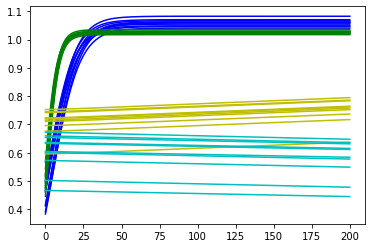

In [ ]:
mat = scipy.io.loadmat(main_path+'Data/20220822truth40.mat')
x = torch.Tensor(mat['YOUT']).float()
plt.plot(x[:,0:10], 'b')
plt.plot(x[:,10:20], 'g')
plt.plot(x[:,20:30], 'y')
plt.plot(x[:,30:40], 'c')
plt.show()

In [ ]:
x.shape

torch.Size([40])

In [ ]:
################ 1.0 truth
mode1_1 = run_ad_truth(main_path)

self.truth_length: 200 of 200 all 
continue_id = None: [0, 10.0] is mapped to [40, 40]
----------------------------- ground truth ------------------------------------


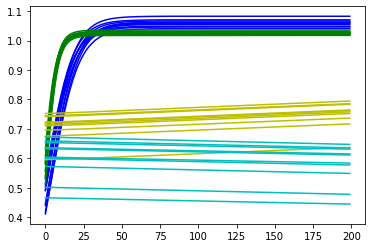

--------------------------------------------------------------------------
using cpu
epoch = 30000
epoch_step = 500
model_name = SimpleNetworkAD
now_string = 2022-08-22-23-13-19
model_save_path_last = /content/drive/My Drive/PINN//train/SimpleNetworkAD_30000_500_0.003_2022-08-22-23-13-19_last.pt
model_save_path_best = /content/drive/My Drive/PINN//train/SimpleNetworkAD_30000_500_0.003_2022-08-22-23-13-19_best.pt
loss_save_path = /content/drive/My Drive/PINN//loss/SimpleNetworkAD_30000_500_0.003_2022-08-22-23-13-19_loss_30000.npy
args = {'epoch': 30000, 'epoch_step': 500, 'lr': 0.003, 'main_path': '/content/drive/My Drive/PINN/', 'save_step': 2000}
config = {'T_all': 10.0, 'T': 10.0, 'T_unit': 0.05, 'T_N': 200, 'N': 200, 'Node': 40, 'k_a': 2.1, 'k_ta': 0.08, 'k_mt': 0.718, 'd_a': 0.06, 'theta': 2, 'k_t': 5, 'k_at': 0.08, 'k_ma': 0.7, 'd_t': 0.06, 'delta': 2, 'k_tn': 0.03566, 'k_mtn': 0.08, 'gamma': 3, 'k_an': 0.05, 'k_man': 5.022, 'beta': 3, 'k_atn': 0.03, 'k_r': 0.0846, 'k_nc': 0.3596,

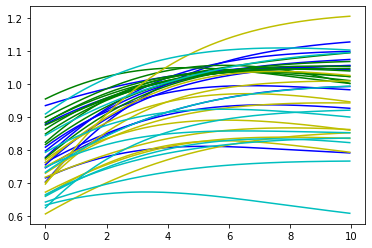

Epoch [02500/30000] Loss:0.057584 Loss_1:0.033799 Loss_2:0.023785 Loss_3:0.000000 Lr:0.002400 Time:42.553609s (3.39min in total, 37.26min remains)
Epoch [03000/30000] Loss:0.047330 Loss_1:0.029326 Loss_2:0.018005 Loss_3:0.000000 Lr:0.002308 Time:40.973725s (4.07min in total, 36.63min remains)
Epoch [03500/30000] Loss:0.038510 Loss_1:0.025091 Loss_2:0.013418 Loss_3:0.000000 Lr:0.002222 Time:39.217452s (4.72min in total, 35.76min remains)
Epoch [04000/30000] Loss:0.031378 Loss_1:0.021176 Loss_2:0.010202 Loss_3:0.000000 Lr:0.002143 Time:40.762843s (5.40min in total, 35.12min remains)
Testing & drawing...


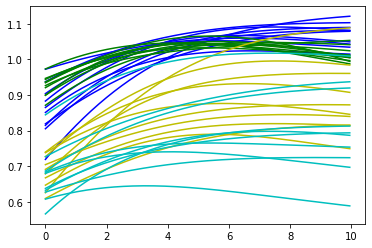

Epoch [04500/30000] Loss:0.025843 Loss_1:0.017596 Loss_2:0.008247 Loss_3:0.000000 Lr:0.002069 Time:40.829879s (6.08min in total, 34.47min remains)
Epoch [05000/30000] Loss:0.021426 Loss_1:0.014343 Loss_2:0.007083 Loss_3:0.000000 Lr:0.002000 Time:38.797529s (6.73min in total, 33.65min remains)
Epoch [05500/30000] Loss:0.017773 Loss_1:0.011448 Loss_2:0.006325 Loss_3:0.000000 Lr:0.001935 Time:40.772665s (7.41min in total, 33.01min remains)
Epoch [06000/30000] Loss:0.014735 Loss_1:0.008963 Loss_2:0.005773 Loss_3:0.000000 Lr:0.001875 Time:41.729588s (8.11min in total, 32.42min remains)
Testing & drawing...


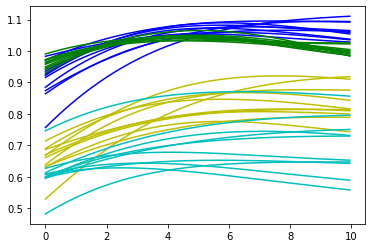

Epoch [06500/30000] Loss:0.012254 Loss_1:0.006933 Loss_2:0.005321 Loss_3:0.000000 Lr:0.001818 Time:38.974897s (8.75min in total, 31.65min remains)
Epoch [07000/30000] Loss:0.010300 Loss_1:0.005380 Loss_2:0.004921 Loss_3:0.000000 Lr:0.001765 Time:40.562151s (9.43min in total, 30.99min remains)
Epoch [07500/30000] Loss:0.008843 Loss_1:0.004290 Loss_2:0.004553 Loss_3:0.000000 Lr:0.001714 Time:40.768123s (10.11min in total, 30.33min remains)
Epoch [08000/30000] Loss:0.007814 Loss_1:0.003604 Loss_2:0.004210 Loss_3:0.000000 Lr:0.001667 Time:40.571737s (10.79min in total, 29.66min remains)
Testing & drawing...


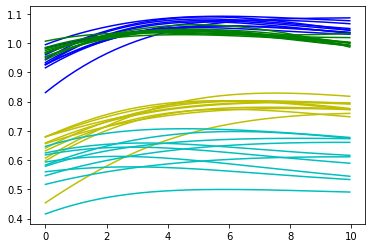

Epoch [08500/30000] Loss:0.007116 Loss_1:0.003226 Loss_2:0.003890 Loss_3:0.000000 Lr:0.001622 Time:39.160658s (11.44min in total, 28.93min remains)
Epoch [09000/30000] Loss:0.006638 Loss_1:0.003043 Loss_2:0.003594 Loss_3:0.000000 Lr:0.001579 Time:41.279523s (12.13min in total, 28.30min remains)
Epoch [09500/30000] Loss:0.006289 Loss_1:0.002964 Loss_2:0.003325 Loss_3:0.000000 Lr:0.001538 Time:40.128522s (12.80min in total, 27.61min remains)
Epoch [10000/30000] Loss:0.006005 Loss_1:0.002926 Loss_2:0.003079 Loss_3:0.000000 Lr:0.001500 Time:40.172874s (13.47min in total, 26.93min remains)
Testing & drawing...


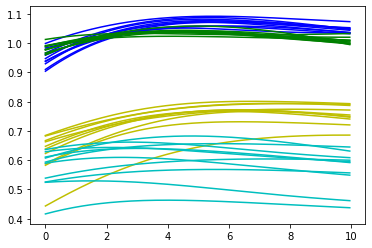

Epoch [10500/30000] Loss:0.005750 Loss_1:0.002900 Loss_2:0.002850 Loss_3:0.000000 Lr:0.001463 Time:39.003871s (14.12min in total, 26.21min remains)
Epoch [11000/30000] Loss:0.005515 Loss_1:0.002871 Loss_2:0.002643 Loss_3:0.000000 Lr:0.001429 Time:40.077021s (14.78min in total, 25.54min remains)
Epoch [11500/30000] Loss:0.005298 Loss_1:0.002840 Loss_2:0.002458 Loss_3:0.000000 Lr:0.001395 Time:39.998092s (15.45min in total, 24.85min remains)
Epoch [12000/30000] Loss:0.005094 Loss_1:0.002812 Loss_2:0.002282 Loss_3:0.000000 Lr:0.001364 Time:39.865262s (16.11min in total, 24.17min remains)
Testing & drawing...


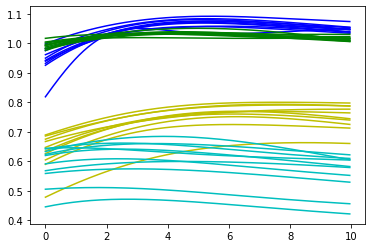

Epoch [12500/30000] Loss:0.004891 Loss_1:0.002776 Loss_2:0.002115 Loss_3:0.000000 Lr:0.001333 Time:40.185724s (16.78min in total, 23.50min remains)
Epoch [13000/30000] Loss:0.004668 Loss_1:0.002718 Loss_2:0.001950 Loss_3:0.000000 Lr:0.001304 Time:40.369692s (17.46min in total, 22.83min remains)
Epoch [13500/30000] Loss:0.004459 Loss_1:0.002681 Loss_2:0.001778 Loss_3:0.000000 Lr:0.001277 Time:38.915559s (18.11min in total, 22.13min remains)
Epoch [14000/30000] Loss:0.004360 Loss_1:0.002680 Loss_2:0.001680 Loss_3:0.000000 Lr:0.001250 Time:41.558533s (18.80min in total, 21.48min remains)
Testing & drawing...


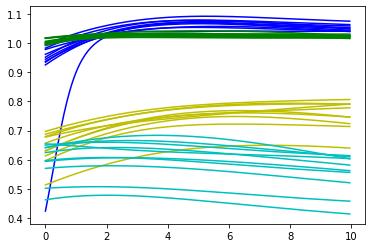

Epoch [14500/30000] Loss:0.004284 Loss_1:0.002671 Loss_2:0.001614 Loss_3:0.000000 Lr:0.001224 Time:40.272174s (19.47min in total, 20.81min remains)
Epoch [15000/30000] Loss:0.004216 Loss_1:0.002646 Loss_2:0.001570 Loss_3:0.000000 Lr:0.001200 Time:42.172114s (20.17min in total, 20.17min remains)
Epoch [15500/30000] Loss:0.004143 Loss_1:0.002598 Loss_2:0.001545 Loss_3:0.000000 Lr:0.001176 Time:39.580220s (20.83min in total, 19.49min remains)
Epoch [16000/30000] Loss:0.004050 Loss_1:0.002509 Loss_2:0.001541 Loss_3:0.000000 Lr:0.001154 Time:39.310749s (21.49min in total, 18.80min remains)
Testing & drawing...


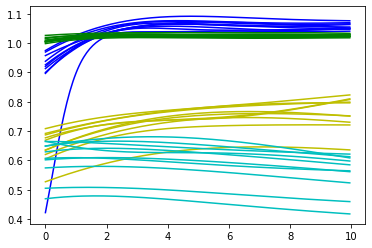

Epoch [16500/30000] Loss:0.003920 Loss_1:0.002361 Loss_2:0.001560 Loss_3:0.000000 Lr:0.001132 Time:41.293593s (22.18min in total, 18.14min remains)
Epoch [17000/30000] Loss:0.003697 Loss_1:0.002130 Loss_2:0.001566 Loss_3:0.000000 Lr:0.001111 Time:41.319731s (22.86min in total, 17.48min remains)
Epoch [17500/30000] Loss:0.003344 Loss_1:0.001855 Loss_2:0.001489 Loss_3:0.000000 Lr:0.001091 Time:39.926956s (23.53min in total, 16.81min remains)
Epoch [18000/30000] Loss:0.002938 Loss_1:0.001519 Loss_2:0.001419 Loss_3:0.000000 Lr:0.001071 Time:44.289994s (24.27min in total, 16.18min remains)
Testing & drawing...


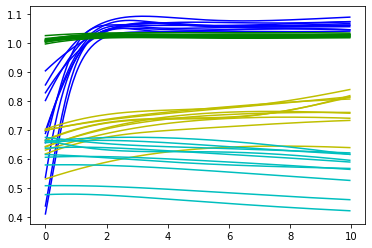

Epoch [18500/30000] Loss:0.002524 Loss_1:0.001237 Loss_2:0.001288 Loss_3:0.000000 Lr:0.001053 Time:41.767566s (24.96min in total, 15.52min remains)
Epoch [19000/30000] Loss:0.002177 Loss_1:0.001049 Loss_2:0.001128 Loss_3:0.000000 Lr:0.001034 Time:41.697235s (25.66min in total, 14.86min remains)
Epoch [19500/30000] Loss:0.002001 Loss_1:0.000955 Loss_2:0.001045 Loss_3:0.000000 Lr:0.001017 Time:40.763961s (26.34min in total, 14.18min remains)
Epoch [20000/30000] Loss:0.001883 Loss_1:0.000913 Loss_2:0.000971 Loss_3:0.000000 Lr:0.001000 Time:41.024285s (27.02min in total, 13.51min remains)
Testing & drawing...


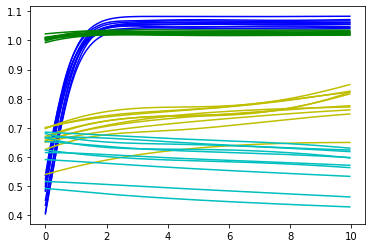

Epoch [20500/30000] Loss:0.001868 Loss_1:0.000908 Loss_2:0.000960 Loss_3:0.000000 Lr:0.000984 Time:41.234052s (27.71min in total, 12.84min remains)
Epoch [21000/30000] Loss:0.001854 Loss_1:0.000904 Loss_2:0.000950 Loss_3:0.000000 Lr:0.000968 Time:42.927067s (28.42min in total, 12.18min remains)
Epoch [21500/30000] Loss:0.001841 Loss_1:0.000898 Loss_2:0.000943 Loss_3:0.000000 Lr:0.000952 Time:41.370878s (29.11min in total, 11.51min remains)
Epoch [22000/30000] Loss:0.001825 Loss_1:0.000887 Loss_2:0.000939 Loss_3:0.000000 Lr:0.000937 Time:41.876085s (29.81min in total, 10.84min remains)
Testing & drawing...


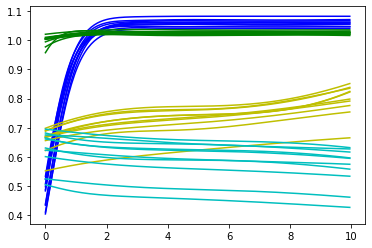

Epoch [22500/30000] Loss:0.001784 Loss_1:0.000848 Loss_2:0.000936 Loss_3:0.000000 Lr:0.000923 Time:43.105408s (30.53min in total, 10.18min remains)
Epoch [23000/30000] Loss:0.001747 Loss_1:0.000820 Loss_2:0.000927 Loss_3:0.000000 Lr:0.000909 Time:40.361074s (31.20min in total, 9.50min remains)
Epoch [23500/30000] Loss:0.001732 Loss_1:0.000814 Loss_2:0.000918 Loss_3:0.000000 Lr:0.000896 Time:41.217855s (31.89min in total, 8.82min remains)
Epoch [24000/30000] Loss:0.001730 Loss_1:0.000808 Loss_2:0.000923 Loss_3:0.000000 Lr:0.000882 Time:42.598912s (32.60min in total, 8.15min remains)
Testing & drawing...


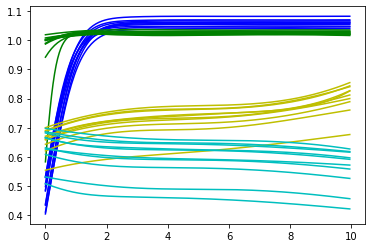

Epoch [24500/30000] Loss:0.001724 Loss_1:0.000798 Loss_2:0.000926 Loss_3:0.000000 Lr:0.000870 Time:41.178253s (33.29min in total, 7.47min remains)
Epoch [25000/30000] Loss:0.001696 Loss_1:0.000770 Loss_2:0.000926 Loss_3:0.000000 Lr:0.000857 Time:40.298374s (33.96min in total, 6.79min remains)
Epoch [25500/30000] Loss:0.001624 Loss_1:0.000717 Loss_2:0.000907 Loss_3:0.000000 Lr:0.000845 Time:41.144522s (34.64min in total, 6.11min remains)
Epoch [26000/30000] Loss:0.001620 Loss_1:0.000707 Loss_2:0.000914 Loss_3:0.000000 Lr:0.000833 Time:40.640256s (35.32min in total, 5.43min remains)
Testing & drawing...


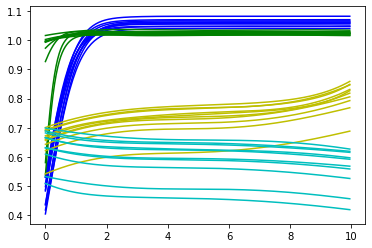

Epoch [26500/30000] Loss:0.001568 Loss_1:0.000653 Loss_2:0.000915 Loss_3:0.000000 Lr:0.000822 Time:41.233986s (36.01min in total, 4.76min remains)
Epoch [27000/30000] Loss:0.001548 Loss_1:0.000631 Loss_2:0.000917 Loss_3:0.000000 Lr:0.000811 Time:40.889383s (36.69min in total, 4.08min remains)
Epoch [27500/30000] Loss:0.001511 Loss_1:0.000612 Loss_2:0.000900 Loss_3:0.000000 Lr:0.000800 Time:41.007097s (37.37min in total, 3.40min remains)
Epoch [28000/30000] Loss:0.001472 Loss_1:0.000582 Loss_2:0.000890 Loss_3:0.000000 Lr:0.000789 Time:40.878836s (38.06min in total, 2.72min remains)
Testing & drawing...


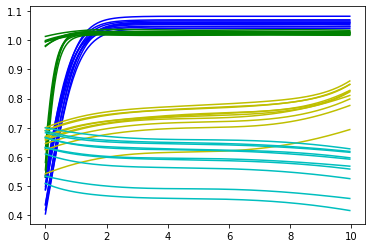

Epoch [28500/30000] Loss:0.001466 Loss_1:0.000575 Loss_2:0.000892 Loss_3:0.000000 Lr:0.000779 Time:39.041030s (38.71min in total, 2.04min remains)
Epoch [29000/30000] Loss:0.001462 Loss_1:0.000564 Loss_2:0.000899 Loss_3:0.000000 Lr:0.000769 Time:40.951996s (39.39min in total, 1.36min remains)
Epoch [29500/30000] Loss:0.001447 Loss_1:0.000548 Loss_2:0.000899 Loss_3:0.000000 Lr:0.000759 Time:40.145897s (40.06min in total, 0.68min remains)
Epoch [30000/30000] Loss:0.001396 Loss_1:0.000489 Loss_2:0.000907 Loss_3:0.000000 Lr:0.000750 Time:41.325722s (40.75min in total, 0.00min remains)
Testing & drawing...


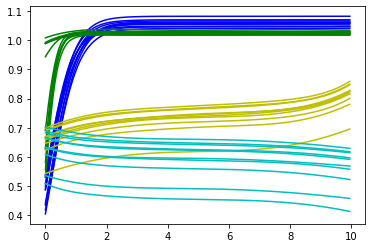

tensor board path: /content/drive/My Drive/PINN//board/SimpleNetworkAD_30000_500_0.003_2022-08-22-23-13-19_board
%load_ext tensorboard
%tensorboard --logdir=/content/drive/My\ Drive/PINN//board/SimpleNetworkAD_30000_500_0.003_2022-08-22-23-13-19_board


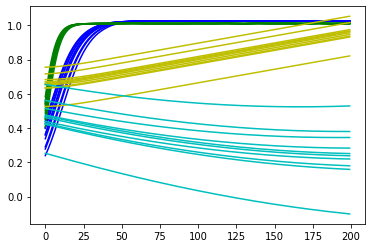

In [ ]:
# truth rt = 1
mode1_3 = run_ad_truth(main_path)

self.truth_length: 20 of 200 all 
continue_id = None: [0, 10.0] is mapped to [40, 40]
----------------------------- ground truth ------------------------------------


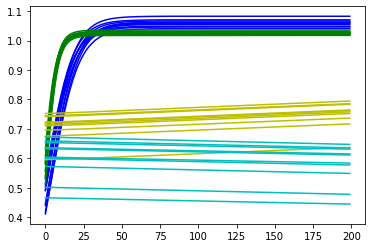

--------------------------------------------------------------------------
using cpu
epoch = 30000
epoch_step = 500
model_name = SimpleNetworkAD
now_string = 2022-08-23-00-11-01
model_save_path_last = /content/drive/My Drive/PINN//train/SimpleNetworkAD_30000_500_0.003_2022-08-23-00-11-01_last.pt
model_save_path_best = /content/drive/My Drive/PINN//train/SimpleNetworkAD_30000_500_0.003_2022-08-23-00-11-01_best.pt
loss_save_path = /content/drive/My Drive/PINN//loss/SimpleNetworkAD_30000_500_0.003_2022-08-23-00-11-01_loss_30000.npy
args = {'epoch': 30000, 'epoch_step': 500, 'lr': 0.003, 'main_path': '/content/drive/My Drive/PINN/', 'save_step': 2000}
config = {'T_all': 10.0, 'T': 10.0, 'T_unit': 0.05, 'T_N': 200, 'N': 200, 'Node': 40, 'k_a': 2.1, 'k_ta': 0.08, 'k_mt': 0.718, 'd_a': 0.06, 'theta': 2, 'k_t': 5, 'k_at': 0.08, 'k_ma': 0.7, 'd_t': 0.06, 'delta': 2, 'k_tn': 0.03566, 'k_mtn': 0.08, 'gamma': 3, 'k_an': 0.05, 'k_man': 5.022, 'beta': 3, 'k_atn': 0.03, 'k_r': 0.0846, 'k_nc': 0.3596,

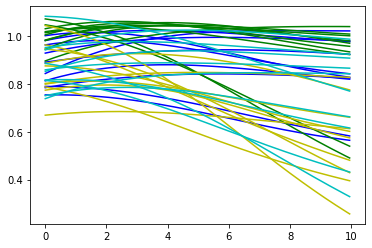

Epoch [02500/30000] Loss:0.100532 Loss_1:0.049516 Loss_2:0.051016 Loss_3:0.000000 Lr:0.002400 Time:40.680566s (3.39min in total, 37.27min remains)
Epoch [03000/30000] Loss:0.078976 Loss_1:0.046096 Loss_2:0.032880 Loss_3:0.000000 Lr:0.002308 Time:40.878229s (4.07min in total, 36.62min remains)
Epoch [03500/30000] Loss:0.065603 Loss_1:0.041953 Loss_2:0.023650 Loss_3:0.000000 Lr:0.002222 Time:39.771876s (4.73min in total, 35.83min remains)
Epoch [04000/30000] Loss:0.054289 Loss_1:0.037890 Loss_2:0.016399 Loss_3:0.000000 Lr:0.002143 Time:40.878067s (5.41min in total, 35.19min remains)
Testing & drawing...


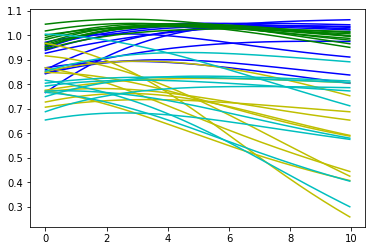

Epoch [04500/30000] Loss:0.045004 Loss_1:0.034138 Loss_2:0.010866 Loss_3:0.000000 Lr:0.002069 Time:41.889470s (6.11min in total, 34.63min remains)
Epoch [05000/30000] Loss:0.038695 Loss_1:0.030531 Loss_2:0.008164 Loss_3:0.000000 Lr:0.002000 Time:40.555907s (6.79min in total, 33.94min remains)
Epoch [05500/30000] Loss:0.034367 Loss_1:0.026893 Loss_2:0.007474 Loss_3:0.000000 Lr:0.001935 Time:40.689949s (7.47min in total, 33.26min remains)
Epoch [06000/30000] Loss:0.030834 Loss_1:0.023409 Loss_2:0.007425 Loss_3:0.000000 Lr:0.001875 Time:40.896552s (8.15min in total, 32.59min remains)
Testing & drawing...


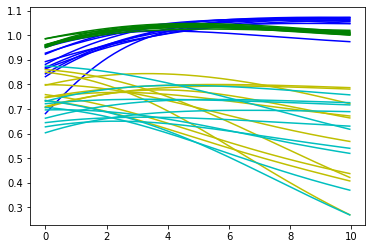

Epoch [06500/30000] Loss:0.027807 Loss_1:0.020305 Loss_2:0.007502 Loss_3:0.000000 Lr:0.001818 Time:39.187613s (8.80min in total, 31.82min remains)
Epoch [07000/30000] Loss:0.025244 Loss_1:0.017649 Loss_2:0.007595 Loss_3:0.000000 Lr:0.001765 Time:40.407092s (9.47min in total, 31.13min remains)
Epoch [07500/30000] Loss:0.023038 Loss_1:0.015394 Loss_2:0.007644 Loss_3:0.000000 Lr:0.001714 Time:42.111623s (10.18min in total, 30.53min remains)
Epoch [08000/30000] Loss:0.021238 Loss_1:0.013664 Loss_2:0.007575 Loss_3:0.000000 Lr:0.001667 Time:38.946335s (10.82min in total, 29.77min remains)
Testing & drawing...


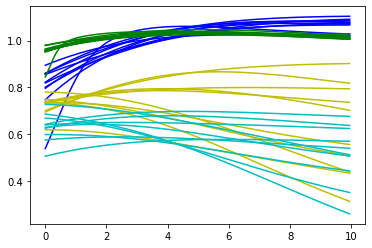

Epoch [08500/30000] Loss:0.019769 Loss_1:0.012348 Loss_2:0.007420 Loss_3:0.000000 Lr:0.001622 Time:40.585502s (11.50min in total, 29.09min remains)
Epoch [09000/30000] Loss:0.018523 Loss_1:0.011344 Loss_2:0.007179 Loss_3:0.000000 Lr:0.001579 Time:40.622155s (12.18min in total, 28.42min remains)
Epoch [09500/30000] Loss:0.017369 Loss_1:0.010519 Loss_2:0.006850 Loss_3:0.000000 Lr:0.001538 Time:39.186040s (12.83min in total, 27.69min remains)
Epoch [10000/30000] Loss:0.016186 Loss_1:0.009764 Loss_2:0.006422 Loss_3:0.000000 Lr:0.001500 Time:40.548429s (13.51min in total, 27.01min remains)
Testing & drawing...


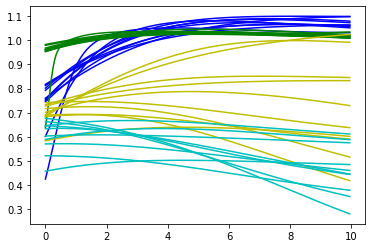

Epoch [10500/30000] Loss:0.014930 Loss_1:0.009027 Loss_2:0.005903 Loss_3:0.000000 Lr:0.001463 Time:40.865468s (14.19min in total, 26.35min remains)
Epoch [11000/30000] Loss:0.013599 Loss_1:0.008281 Loss_2:0.005318 Loss_3:0.000000 Lr:0.001429 Time:40.240504s (14.86min in total, 25.67min remains)
Epoch [11500/30000] Loss:0.012207 Loss_1:0.007520 Loss_2:0.004687 Loss_3:0.000000 Lr:0.001395 Time:40.522341s (15.53min in total, 24.99min remains)
Epoch [12000/30000] Loss:0.010780 Loss_1:0.006765 Loss_2:0.004015 Loss_3:0.000000 Lr:0.001364 Time:40.008821s (16.20min in total, 24.30min remains)
Testing & drawing...


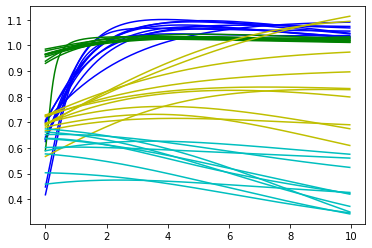

Epoch [12500/30000] Loss:0.009363 Loss_1:0.006028 Loss_2:0.003335 Loss_3:0.000000 Lr:0.001333 Time:39.045130s (16.85min in total, 23.59min remains)
Epoch [13000/30000] Loss:0.008010 Loss_1:0.005288 Loss_2:0.002722 Loss_3:0.000000 Lr:0.001304 Time:39.840279s (17.52min in total, 22.91min remains)
Epoch [13500/30000] Loss:0.006811 Loss_1:0.004666 Loss_2:0.002145 Loss_3:0.000000 Lr:0.001277 Time:38.664882s (18.16min in total, 22.20min remains)
Epoch [14000/30000] Loss:0.006034 Loss_1:0.004344 Loss_2:0.001690 Loss_3:0.000000 Lr:0.001250 Time:41.648993s (18.85min in total, 21.55min remains)
Testing & drawing...


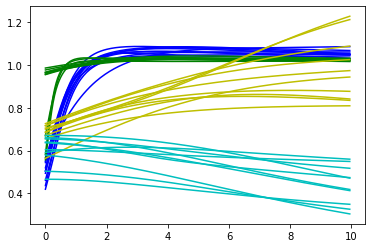

Epoch [14500/30000] Loss:0.005579 Loss_1:0.004173 Loss_2:0.001406 Loss_3:0.000000 Lr:0.001224 Time:41.856806s (19.55min in total, 20.90min remains)
Epoch [15000/30000] Loss:0.005289 Loss_1:0.004033 Loss_2:0.001256 Loss_3:0.000000 Lr:0.001200 Time:38.588394s (20.20min in total, 20.20min remains)
Epoch [15500/30000] Loss:0.005074 Loss_1:0.003880 Loss_2:0.001195 Loss_3:0.000000 Lr:0.001176 Time:40.890631s (20.88min in total, 19.53min remains)
Epoch [16000/30000] Loss:0.004869 Loss_1:0.003677 Loss_2:0.001193 Loss_3:0.000000 Lr:0.001154 Time:42.073378s (21.58min in total, 18.88min remains)
Testing & drawing...


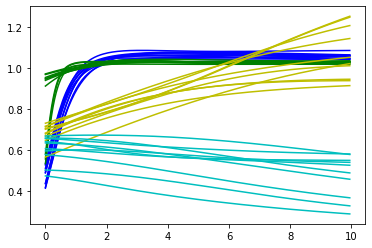

Epoch [16500/30000] Loss:0.004615 Loss_1:0.003384 Loss_2:0.001231 Loss_3:0.000000 Lr:0.001132 Time:40.634664s (22.26min in total, 18.21min remains)
Epoch [17000/30000] Loss:0.004189 Loss_1:0.002933 Loss_2:0.001257 Loss_3:0.000000 Lr:0.001111 Time:41.609650s (22.95min in total, 17.55min remains)
Epoch [17500/30000] Loss:0.003500 Loss_1:0.002363 Loss_2:0.001137 Loss_3:0.000000 Lr:0.001091 Time:41.381673s (23.64min in total, 16.88min remains)
Epoch [18000/30000] Loss:0.002813 Loss_1:0.001683 Loss_2:0.001131 Loss_3:0.000000 Lr:0.001071 Time:39.358032s (24.29min in total, 16.20min remains)
Testing & drawing...


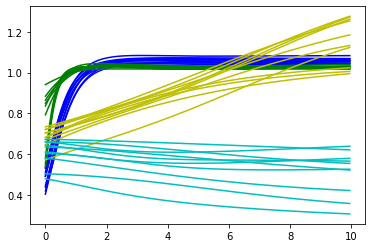

Epoch [18500/30000] Loss:0.001646 Loss_1:0.000770 Loss_2:0.000876 Loss_3:0.000000 Lr:0.001053 Time:40.881807s (24.98min in total, 15.53min remains)
Epoch [19000/30000] Loss:0.000795 Loss_1:0.000373 Loss_2:0.000422 Loss_3:0.000000 Lr:0.001034 Time:40.280449s (25.65min in total, 14.85min remains)
Epoch [19500/30000] Loss:0.000541 Loss_1:0.000264 Loss_2:0.000277 Loss_3:0.000000 Lr:0.001017 Time:38.636862s (26.29min in total, 14.16min remains)
Epoch [20000/30000] Loss:0.000384 Loss_1:0.000146 Loss_2:0.000239 Loss_3:0.000000 Lr:0.001000 Time:39.382703s (26.95min in total, 13.47min remains)
Testing & drawing...


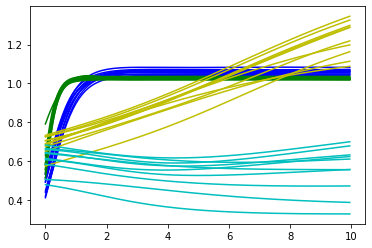

Epoch [20500/30000] Loss:0.000174 Loss_1:0.000051 Loss_2:0.000122 Loss_3:0.000000 Lr:0.000984 Time:40.939606s (27.63min in total, 12.80min remains)
Epoch [21000/30000] Loss:0.000109 Loss_1:0.000043 Loss_2:0.000066 Loss_3:0.000000 Lr:0.000968 Time:40.262156s (28.30min in total, 12.13min remains)
Epoch [21500/30000] Loss:0.000097 Loss_1:0.000039 Loss_2:0.000058 Loss_3:0.000000 Lr:0.000952 Time:40.521878s (28.98min in total, 11.46min remains)
Epoch [22000/30000] Loss:0.000078 Loss_1:0.000037 Loss_2:0.000041 Loss_3:0.000000 Lr:0.000937 Time:40.340547s (29.65min in total, 10.78min remains)
Testing & drawing...


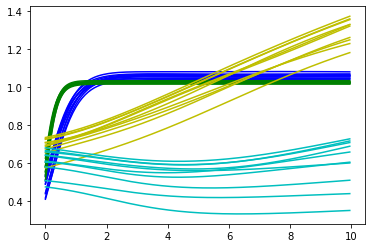

Epoch [22500/30000] Loss:0.000072 Loss_1:0.000035 Loss_2:0.000037 Loss_3:0.000000 Lr:0.000923 Time:38.983681s (30.30min in total, 10.10min remains)
Epoch [23000/30000] Loss:0.000068 Loss_1:0.000034 Loss_2:0.000034 Loss_3:0.000000 Lr:0.000909 Time:40.251151s (30.97min in total, 9.43min remains)
Epoch [23500/30000] Loss:0.000063 Loss_1:0.000034 Loss_2:0.000030 Loss_3:0.000000 Lr:0.000896 Time:39.481905s (31.63min in total, 8.75min remains)
Epoch [24000/30000] Loss:0.000061 Loss_1:0.000033 Loss_2:0.000028 Loss_3:0.000000 Lr:0.000882 Time:40.981230s (32.31min in total, 8.08min remains)
Testing & drawing...


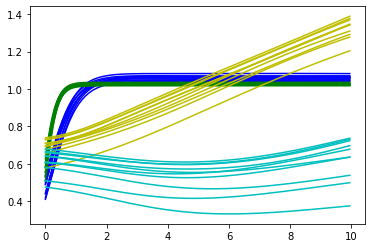

Epoch [24500/30000] Loss:0.000059 Loss_1:0.000032 Loss_2:0.000027 Loss_3:0.000000 Lr:0.000870 Time:41.499826s (33.00min in total, 7.41min remains)
Epoch [25000/30000] Loss:0.000058 Loss_1:0.000031 Loss_2:0.000027 Loss_3:0.000000 Lr:0.000857 Time:38.495089s (33.64min in total, 6.73min remains)
Epoch [25500/30000] Loss:0.000054 Loss_1:0.000030 Loss_2:0.000025 Loss_3:0.000000 Lr:0.000845 Time:41.127024s (34.33min in total, 6.06min remains)
Epoch [26000/30000] Loss:0.000049 Loss_1:0.000028 Loss_2:0.000021 Loss_3:0.000000 Lr:0.000833 Time:40.296499s (35.00min in total, 5.38min remains)
Testing & drawing...


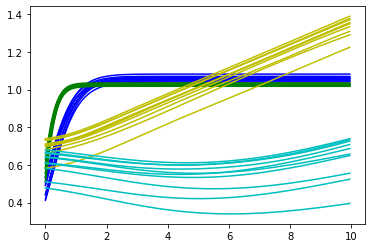

Epoch [26500/30000] Loss:0.000049 Loss_1:0.000028 Loss_2:0.000021 Loss_3:0.000000 Lr:0.000822 Time:39.316018s (35.66min in total, 4.71min remains)
Epoch [27000/30000] Loss:0.000048 Loss_1:0.000027 Loss_2:0.000021 Loss_3:0.000000 Lr:0.000811 Time:40.697658s (36.33min in total, 4.04min remains)
Epoch [27500/30000] Loss:0.000049 Loss_1:0.000027 Loss_2:0.000022 Loss_3:0.000000 Lr:0.000800 Time:40.810954s (37.01min in total, 3.36min remains)
Epoch [28000/30000] Loss:0.000047 Loss_1:0.000027 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000789 Time:41.043716s (37.70min in total, 2.69min remains)
Testing & drawing...


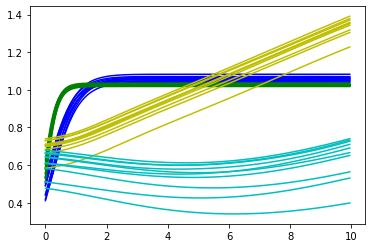

Epoch [28500/30000] Loss:0.000055 Loss_1:0.000027 Loss_2:0.000029 Loss_3:0.000000 Lr:0.000779 Time:41.495792s (38.39min in total, 2.02min remains)
Epoch [29000/30000] Loss:0.000047 Loss_1:0.000027 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000769 Time:41.653998s (39.08min in total, 1.35min remains)
Epoch [29500/30000] Loss:0.000047 Loss_1:0.000026 Loss_2:0.000021 Loss_3:0.000000 Lr:0.000759 Time:40.029371s (39.75min in total, 0.67min remains)
Epoch [30000/30000] Loss:0.000046 Loss_1:0.000026 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000750 Time:40.356735s (40.42min in total, 0.00min remains)
Testing & drawing...


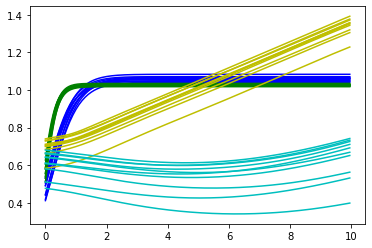

tensor board path: /content/drive/My Drive/PINN//board/SimpleNetworkAD_30000_500_0.003_2022-08-23-00-11-01_board
%load_ext tensorboard
%tensorboard --logdir=/content/drive/My\ Drive/PINN//board/SimpleNetworkAD_30000_500_0.003_2022-08-23-00-11-01_board


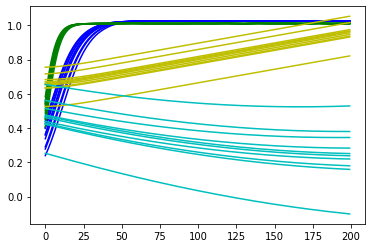

In [ ]:
# truth rt = 0.1
mode1_4 = run_ad_truth(main_path)

self.truth_length: 20 of 200 all 
continue_id = None: [0, 10.0] is mapped to [40, 40]
----------------------------- ground truth ------------------------------------


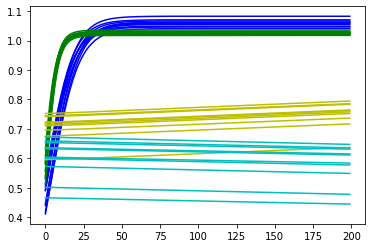

--------------------------------------------------------------------------
using cpu
epoch = 100000
epoch_step = 1000
model_name = SimpleNetworkAD
now_string = 2022-08-23-01-04-50
model_save_path_last = /content/drive/My Drive/PINN//train/SimpleNetworkAD_100000_1000_0.003_2022-08-23-01-04-50_last.pt
model_save_path_best = /content/drive/My Drive/PINN//train/SimpleNetworkAD_100000_1000_0.003_2022-08-23-01-04-50_best.pt
loss_save_path = /content/drive/My Drive/PINN//loss/SimpleNetworkAD_100000_1000_0.003_2022-08-23-01-04-50_loss_100000.npy
args = {'epoch': 100000, 'epoch_step': 1000, 'lr': 0.003, 'main_path': '/content/drive/My Drive/PINN/', 'save_step': 10000}
config = {'T_all': 10.0, 'T': 10.0, 'T_unit': 0.05, 'T_N': 200, 'N': 200, 'Node': 40, 'k_a': 2.1, 'k_ta': 0.08, 'k_mt': 0.718, 'd_a': 0.06, 'theta': 2, 'k_t': 5, 'k_at': 0.08, 'k_ma': 0.7, 'd_t': 0.06, 'delta': 2, 'k_tn': 0.03566, 'k_mtn': 0.08, 'gamma': 3, 'k_an': 0.05, 'k_man': 5.022, 'beta': 3, 'k_atn': 0.03, 'k_r': 0.0846, 'k_

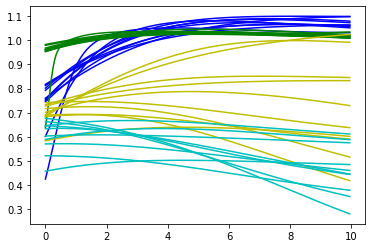

Epoch [11000/100000] Loss:0.013599 Loss_1:0.008281 Loss_2:0.005318 Loss_3:0.000000 Lr:0.001429 Time:79.429415s (14.57min in total, 117.85min remains)
Epoch [12000/100000] Loss:0.010780 Loss_1:0.006765 Loss_2:0.004015 Loss_3:0.000000 Lr:0.001364 Time:80.506835s (15.91min in total, 116.65min remains)
Epoch [13000/100000] Loss:0.008010 Loss_1:0.005288 Loss_2:0.002722 Loss_3:0.000000 Lr:0.001304 Time:78.794507s (17.22min in total, 115.25min remains)
Epoch [14000/100000] Loss:0.006034 Loss_1:0.004344 Loss_2:0.001690 Loss_3:0.000000 Lr:0.001250 Time:79.141219s (18.54min in total, 113.89min remains)
Epoch [15000/100000] Loss:0.005289 Loss_1:0.004033 Loss_2:0.001256 Loss_3:0.000000 Lr:0.001200 Time:79.914849s (19.87min in total, 112.61min remains)
Epoch [16000/100000] Loss:0.004869 Loss_1:0.003677 Loss_2:0.001193 Loss_3:0.000000 Lr:0.001154 Time:78.796510s (21.18min in total, 111.22min remains)
Epoch [17000/100000] Loss:0.004189 Loss_1:0.002933 Loss_2:0.001257 Loss_3:0.000000 Lr:0.001111 Time:

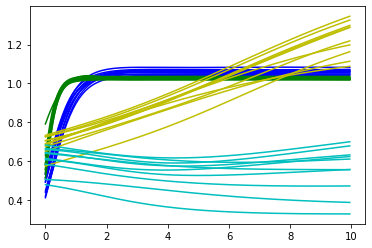

Epoch [21000/100000] Loss:0.000109 Loss_1:0.000043 Loss_2:0.000066 Loss_3:0.000000 Lr:0.000968 Time:78.923445s (27.74min in total, 104.35min remains)
Epoch [22000/100000] Loss:0.000078 Loss_1:0.000037 Loss_2:0.000041 Loss_3:0.000000 Lr:0.000937 Time:80.445780s (29.08min in total, 103.10min remains)
Epoch [23000/100000] Loss:0.000068 Loss_1:0.000034 Loss_2:0.000034 Loss_3:0.000000 Lr:0.000909 Time:80.928821s (30.43min in total, 101.86min remains)
Epoch [24000/100000] Loss:0.000061 Loss_1:0.000033 Loss_2:0.000028 Loss_3:0.000000 Lr:0.000882 Time:79.143935s (31.75min in total, 100.53min remains)
Epoch [25000/100000] Loss:0.000058 Loss_1:0.000031 Loss_2:0.000027 Loss_3:0.000000 Lr:0.000857 Time:78.120538s (33.05min in total, 99.14min remains)
Epoch [26000/100000] Loss:0.000049 Loss_1:0.000028 Loss_2:0.000021 Loss_3:0.000000 Lr:0.000833 Time:79.564383s (34.37min in total, 97.83min remains)
Epoch [27000/100000] Loss:0.000048 Loss_1:0.000027 Loss_2:0.000021 Loss_3:0.000000 Lr:0.000811 Time:79

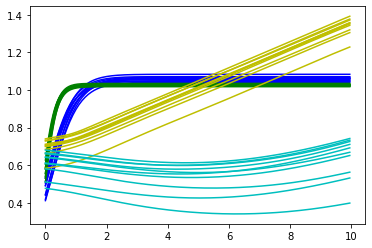

Epoch [31000/100000] Loss:0.000046 Loss_1:0.000026 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000732 Time:78.416323s (40.99min in total, 91.23min remains)
Epoch [32000/100000] Loss:0.000046 Loss_1:0.000026 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000714 Time:80.150697s (42.33min in total, 89.94min remains)
Epoch [33000/100000] Loss:0.000045 Loss_1:0.000025 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000698 Time:82.906224s (43.71min in total, 88.74min remains)
Epoch [34000/100000] Loss:0.000045 Loss_1:0.000025 Loss_2:0.000019 Loss_3:0.000000 Lr:0.000682 Time:79.369163s (45.03min in total, 87.41min remains)
Epoch [35000/100000] Loss:0.000052 Loss_1:0.000025 Loss_2:0.000027 Loss_3:0.000000 Lr:0.000667 Time:80.624969s (46.37min in total, 86.12min remains)
Epoch [36000/100000] Loss:0.000045 Loss_1:0.000025 Loss_2:0.000019 Loss_3:0.000000 Lr:0.000652 Time:82.028615s (47.74min in total, 84.87min remains)
Epoch [37000/100000] Loss:0.000047 Loss_1:0.000024 Loss_2:0.000023 Loss_3:0.000000 Lr:0.000638 Time:78.604

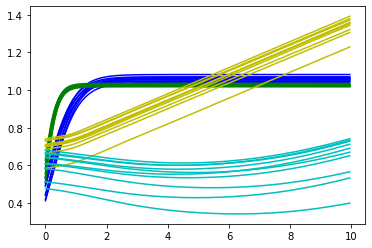

Epoch [41000/100000] Loss:0.000043 Loss_1:0.000023 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000588 Time:79.774283s (54.38min in total, 78.25min remains)
Epoch [42000/100000] Loss:0.000057 Loss_1:0.000024 Loss_2:0.000033 Loss_3:0.000000 Lr:0.000577 Time:79.282700s (55.70min in total, 76.92min remains)
Epoch [43000/100000] Loss:0.000042 Loss_1:0.000023 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000566 Time:81.066367s (57.05min in total, 75.63min remains)
Epoch [44000/100000] Loss:0.000043 Loss_1:0.000023 Loss_2:0.000021 Loss_3:0.000000 Lr:0.000556 Time:78.576774s (58.36min in total, 74.28min remains)
Epoch [45000/100000] Loss:0.000043 Loss_1:0.000022 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000545 Time:79.658702s (59.69min in total, 72.95min remains)
Epoch [46000/100000] Loss:0.000044 Loss_1:0.000022 Loss_2:0.000022 Loss_3:0.000000 Lr:0.000536 Time:79.491578s (61.01min in total, 71.62min remains)
Epoch [47000/100000] Loss:0.000046 Loss_1:0.000022 Loss_2:0.000023 Loss_3:0.000000 Lr:0.000526 Time:79.976

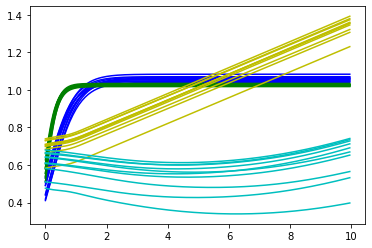

Epoch [51000/100000] Loss:0.000042 Loss_1:0.000022 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000492 Time:80.019552s (67.69min in total, 65.04min remains)
Epoch [52000/100000] Loss:0.000042 Loss_1:0.000022 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000484 Time:80.305341s (69.03min in total, 63.72min remains)
Epoch [53000/100000] Loss:0.000045 Loss_1:0.000022 Loss_2:0.000023 Loss_3:0.000000 Lr:0.000476 Time:80.641339s (70.38min in total, 62.41min remains)
Epoch [54000/100000] Loss:0.000044 Loss_1:0.000022 Loss_2:0.000021 Loss_3:0.000000 Lr:0.000469 Time:80.711216s (71.72min in total, 61.10min remains)
Epoch [55000/100000] Loss:0.000042 Loss_1:0.000022 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000462 Time:80.530738s (73.06min in total, 59.78min remains)
Epoch [56000/100000] Loss:0.000046 Loss_1:0.000023 Loss_2:0.000023 Loss_3:0.000000 Lr:0.000455 Time:80.138360s (74.40min in total, 58.46min remains)
Epoch [57000/100000] Loss:0.000043 Loss_1:0.000022 Loss_2:0.000021 Loss_3:0.000000 Lr:0.000448 Time:80.145

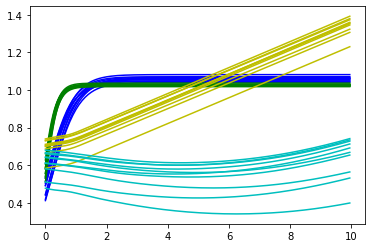

Epoch [61000/100000] Loss:0.000041 Loss_1:0.000021 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000423 Time:82.040138s (81.11min in total, 51.86min remains)
Epoch [62000/100000] Loss:0.000041 Loss_1:0.000021 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000417 Time:79.928159s (82.44min in total, 50.53min remains)
Epoch [63000/100000] Loss:0.000041 Loss_1:0.000021 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000411 Time:80.344549s (83.78min in total, 49.20min remains)
Epoch [64000/100000] Loss:0.000042 Loss_1:0.000021 Loss_2:0.000021 Loss_3:0.000000 Lr:0.000405 Time:81.782062s (85.14min in total, 47.89min remains)
Epoch [65000/100000] Loss:0.000041 Loss_1:0.000021 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000400 Time:78.972739s (86.46min in total, 46.56min remains)
Epoch [66000/100000] Loss:0.000041 Loss_1:0.000021 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000395 Time:80.234282s (87.80min in total, 45.23min remains)
Epoch [67000/100000] Loss:0.000041 Loss_1:0.000021 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000390 Time:79.616

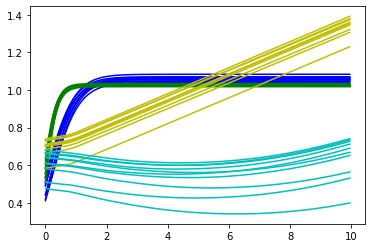

Epoch [71000/100000] Loss:0.000040 Loss_1:0.000021 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000370 Time:80.031264s (94.44min in total, 38.57min remains)
Epoch [72000/100000] Loss:0.000041 Loss_1:0.000021 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000366 Time:78.252667s (95.74min in total, 37.23min remains)
Epoch [73000/100000] Loss:0.000043 Loss_1:0.000021 Loss_2:0.000022 Loss_3:0.000000 Lr:0.000361 Time:79.766387s (97.07min in total, 35.90min remains)
Epoch [74000/100000] Loss:0.000048 Loss_1:0.000021 Loss_2:0.000027 Loss_3:0.000000 Lr:0.000357 Time:78.703256s (98.38min in total, 34.57min remains)
Epoch [75000/100000] Loss:0.000042 Loss_1:0.000021 Loss_2:0.000021 Loss_3:0.000000 Lr:0.000353 Time:79.171462s (99.70min in total, 33.23min remains)
Epoch [76000/100000] Loss:0.000040 Loss_1:0.000021 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000349 Time:78.572696s (101.01min in total, 31.90min remains)
Epoch [77000/100000] Loss:0.000044 Loss_1:0.000021 Loss_2:0.000023 Loss_3:0.000000 Lr:0.000345 Time:77.69

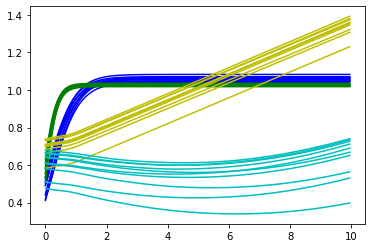

Epoch [81000/100000] Loss:0.000041 Loss_1:0.000021 Loss_2:0.000021 Loss_3:0.000000 Lr:0.000330 Time:79.205745s (107.57min in total, 25.23min remains)
Epoch [82000/100000] Loss:0.000041 Loss_1:0.000020 Loss_2:0.000021 Loss_3:0.000000 Lr:0.000326 Time:79.238174s (108.89min in total, 23.90min remains)
Epoch [83000/100000] Loss:0.000040 Loss_1:0.000020 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000323 Time:78.797659s (110.20min in total, 22.57min remains)
Epoch [84000/100000] Loss:0.000041 Loss_1:0.000021 Loss_2:0.000021 Loss_3:0.000000 Lr:0.000319 Time:77.466882s (111.50min in total, 21.24min remains)
Epoch [85000/100000] Loss:0.000040 Loss_1:0.000020 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000316 Time:78.513618s (112.80min in total, 19.91min remains)
Epoch [86000/100000] Loss:0.000040 Loss_1:0.000020 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000313 Time:79.567069s (114.13min in total, 18.58min remains)
Epoch [87000/100000] Loss:0.000040 Loss_1:0.000020 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000309 Time:

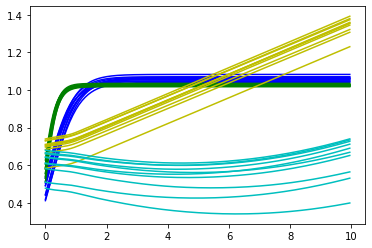

Epoch [91000/100000] Loss:0.000041 Loss_1:0.000021 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000297 Time:78.152610s (120.65min in total, 11.93min remains)
Epoch [92000/100000] Loss:0.000042 Loss_1:0.000020 Loss_2:0.000021 Loss_3:0.000000 Lr:0.000294 Time:77.829892s (121.95min in total, 10.60min remains)
Epoch [93000/100000] Loss:0.000040 Loss_1:0.000020 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000291 Time:78.016809s (123.25min in total, 9.28min remains)
Epoch [94000/100000] Loss:0.000043 Loss_1:0.000020 Loss_2:0.000022 Loss_3:0.000000 Lr:0.000288 Time:76.224558s (124.52min in total, 7.95min remains)
Epoch [95000/100000] Loss:0.000041 Loss_1:0.000020 Loss_2:0.000021 Loss_3:0.000000 Lr:0.000286 Time:77.142329s (125.80min in total, 6.62min remains)
Epoch [96000/100000] Loss:0.000040 Loss_1:0.000020 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000283 Time:76.073326s (127.07min in total, 5.29min remains)
Epoch [97000/100000] Loss:0.000040 Loss_1:0.000020 Loss_2:0.000020 Loss_3:0.000000 Lr:0.000280 Time:77.8

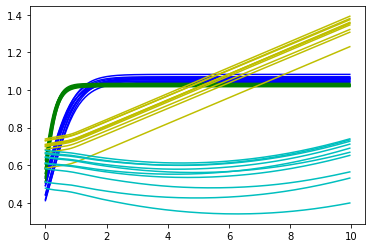

tensor board path: /content/drive/My Drive/PINN//board/SimpleNetworkAD_100000_1000_0.003_2022-08-23-01-04-50_board
%load_ext tensorboard
%tensorboard --logdir=/content/drive/My\ Drive/PINN//board/SimpleNetworkAD_100000_1000_0.003_2022-08-23-01-04-50_board


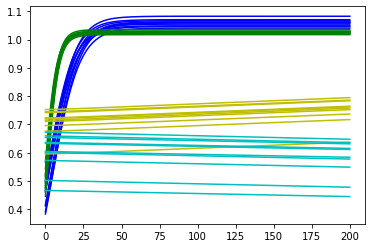

In [ ]:
# truth rt = 0.1
mode1_5 = run_ad_truth(main_path)

In [ ]:
# def loss(self):
  #   print("--------------------------------------------------call loss--------------------------------------------------")
  #   self.eval()
  #   print("--------------------------------------------------called eval--------------------------------------------------")
  #   # for loop *271
  #   y = self.forward(self.x)
  #   print('y', y.shape)

  #   print("y0_pred input, t0",self.t0.shape)
  #   y0_pred = self.forward(self.t0)
  #   print('y0_pred', y0_pred.shape)
  #   # print("y.shape:", y[:, 0:1].shape)
  #   # print(y[:, 0:1])
  #   # print("self.x.shape:", self.x[:, 0:1].shape)
  #   # y_t = torch.gradient(y, spacing=(self.x,))[0]  # y_t = tf.gradients(y, t)[0]
  #   # u = y[:, 0:1]
  #   # v = y[:, 1:2]


  #   A = y[:, 0:1]
  #   T = y[:, 1:2]
  #   N = y[:, 2:3]
  #   C = y[:, 3:4]


    

  #   print("--------------------------------------------------made to gradient--------------------------------------------------")
  #   # u_t = torch.gradient(y[:, 0:1].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0]  # u_t = y_t[:, 0:1]
  #   # v_t = torch.gradient(y[:, 1:2].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 1:2].reshape([self.config.N]),))[0]  # y_t[:, 1:2]
  #   # u_t = u_t.reshape([self.config.N, 1])
  #   # v_t = v_t.reshape([self.config.N, 1])
  #   A_t = torch.gradient(A.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0]  # u_t = y_t[:, 0:1]
  #   T_t = torch.gradient(T.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 1:2].reshape([self.config.N]),))[0]  # y_t[:, 1:2]
  #   N_t = torch.gradient(N.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 2:3].reshape([self.config.N]),))[0]  # u_t = y_t[:, 0:1]
  #   C_t = torch.gradient(C.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 3:4].reshape([self.config.N]),))[0]  # y_t[:, 1:2]

  #   print("--------------------------------------------------gradient before reshape--------------------------------------------------")

  #   print("A_t", A_t.shape)
  #   print("T_t", T_t.shape)
  #   print("N_t", N_t.shape)
  #   print("C_t", C_t.shape)


  #   print("--------------------------------------------------gradient after reshape--------------------------------------------------")

  #   A_t = A_t.reshape([self.config.N, 1])
  #   T_t = T_t.reshape([self.config.N, 1])
  #   N_t = N_t.reshape([self.config.N, 1])
  #   C_t = C_t.reshape([self.config.N, 1])

  #   print("A_t", A_t.shape)
  #   print("T_t", T_t.shape)
  #   print("N_t", N_t.shape)
  #   print("C_t", C_t.shape)


  #   print("--------------------------------------------------finish gradient--------------------------------------------------")
  #   # print(y_t,u_t)
  #   # f_u = u_t - (self.config.alpha - self.config.gamma * v) * u    # nn model
  #   # f_v = v_t - (-self.config.beta + self.config.e * self.config.gamma * u) * v    # nn model
  #   # f_u = u_t - torch.cos(self.decode_t(self.x)[:, 0:1])
  #   # f_v = v_t - torch.cos(self.decode_t(self.x)[:, 1:2])

  #   f_a = self.config.k_a*A*(1 - A) + self.config.k_ta / (np.power((self.config.k_mt/T),self.config.theta) + 1) - self.config.d_a*np.dot(A,Laplacian)
  #   f_t = self.config.k_t*T*(1 - T) + self.config.k_at / (np.power((self.config.k_ma/A),self.config.delta)  + 1) - self.config.d_t*np.dot(T,Laplacian)
  #   f_n = self.config.k_tn / (np.power((self.config.k_mtn/T),self.config.gamma) + 1) + self.config.k_an / (np.power((self.config.k_man/A),self.config.beta) + 1) + self.config.k_atn*A*T
  #   f_c = - self.config.k_r*r + self.config.k_nc / (np.power((self.config.k_mn/N),self.config.alpha) + 1);

  #   f_y = torch.cat((f_a, f_t, f_n, f_c), 1)
  #   print("--------------------------------------------------calculate gradient--------------------------------------------------")
  #   # print((self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),).shape)
  #   # print(u_t.shape)

  #   # u_tt = torch.gradient(u_t, spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0]
  #   # v_tt = torch.gradient(v_t, spacing=(self.decode_t(self.x)[:, 1:2].reshape([self.config.N]),))[0]
    
  #   # print_flag = False  # True # False
  #   # if print_flag:
  #   #     print("u=", u.shape, u, "v=", v.shape, v, "t=", (self.decode_t(self.x)[:, 0:1]).shape, self.decode_t(self.x)[:, 0:1])
  #   #     print("u_t=", u_t, "shape=", u_t.shape, "u_t_minus=", (self.config.alpha - self.config.gamma * v) * u,
  #   #           "shape=", ((self.config.alpha - self.config.gamma * v) * u).shape)
  #   #     print("v_t=", v_t, "shape=", v_t.shape, "v_t_minus=",
  #   #           (-self.config.beta + self.config.e * self.config.gamma * u) * v, "shape=",
  #   #           ((-self.config.beta + self.config.e * self.config.gamma * u) * v).shape)
  #   #     print("self.t0 =", self.t0, "self.encode_y(self.t0)=", self.encode_y(self.t0), "self.y0 =", self.y0,
  #   #           "y0_pred =", y0_pred, "self.y0 - y0_pred =", self.y0 - y0_pred)

  #   # loss_2_weights = [[i, i] for i in range(20000)]  # toy
  #   # loss_2_weights = np.asarray(loss_2_weights)
  #   # loss_2_weights = torch.Tensor(loss_2_weights).float().to(self.device)

  #   # original
  #   # loss_1 = torch.mean(torch.square(self.y0 - y0_pred))
  #   # loss_2 = torch.mean(torch.square(f_y))  # + torch.var(torch.square(f_y))
  #   # loss_3 = torch.mean(torch.square((0.1/(u * u + v * v + 1e-12)))) + torch.mean(torch.square((torch.abs(u) - u))) + torch.mean(torch.square((torch.abs(v) - v)))

  #   # L2 norm
  #   self.loss_norm = torch.nn.MSELoss().to(self.device)
  #   zeros_1D = torch.Tensor([[0.0]] * self.config.N).to(self.device)
  #   zeros_2D = torch.Tensor([[0.0, 0.0]] * self.config.N).to(self.device)
  #   # loss_1 = self.loss_norm(y0_pred, self.y0)
  #   loss_1 = self.loss_norm(y[:self.config.truth_length, :], self.gt_data[:self.config.truth_length, :])



  #   # print("loss_1:", type(loss_1), loss_1.shape, loss_1)
  #   # self.loss_2_weight_numpy = generate_normal_distribution_weight_normal(self.config.N, 2, epoch_ratio)

  #   # self.loss_2_weight_numpy = generate_normal_distribution_weight(self.config.N, 2, (epoch % int(self.config.sliding_window_step)) / self.config.sliding_window_step)
  #   if self.config.loss2_partial_flag:
  #       new_period = int(self.config.continue_period * self.config.T_all / self.config.T_unit)
  #       loss_2 = self.loss_norm(f_y[-new_period:, :], zeros_2D[-new_period:, :])
  #   else:
  #       loss_2 = self.loss_norm(f_y, zeros_2D)  # + torch.var(torch.square(f_y))
  #   # loss_2_details_normed = torch.abs(f_y * torch.Tensor(self.loss_2_weight_numpy).to(self.device)).cpu().detach().numpy()
  #   # loss_2_details_original = torch.abs(f_y).cpu().detach().numpy()
  #   # print("loss_2_details shape:", loss_2_details.shape)
  #   loss_3 = self.loss_norm((0.1/(u * u + v * v + 1e-12)), zeros_1D) + self.loss_norm(torch.abs(u), u) + self.loss_norm(torch.abs(v), v)
  #   # loss_4 = self.match_truth(self.accurate_x, y.cpu().detach().numpy())

  #   # loss_3 = torch.mean(torch.square(1.0 / u - (self.config.e * self.config.gamma / self.config.beta))) + \
  #   #     torch.mean(torch.square(1.0 / v - (self.config.gamma / self.config.alpha)))
  #   # loss_3 = torch.mean(torch.square((torch.abs(u) - u)))

  #   # loss_3 = torch.mean(torch.square((1/(u * u+ 1e-12)))) + torch.mean(torch.square((1/(v * v + 1e-12)))) + torch.mean((torch.abs(u) - u)) + torch.mean((torch.abs(v) - v))

  #   # loss_3 = torch.mean(torch.square((1/(u * u + v * v)))) + torch.mean((torch.abs(u) - u)) + torch.mean((torch.abs(v) - v))  # torch.mean(torch.square((1/(u * u + v * v + 1e-12)))) + torch.mean((torch.abs(u) - u)) + torch.mean((torch.abs(v) - v))
  #   # loss_4 = torch.mean(0.001 / (torch.abs(u_t)+1e-8)) + torch.mean(0.001 / (torch.abs(v_t)+1e-8))
  #   # loss_5 = torch.mean(0.001 / (torch.abs(u_tt)+1e-8)) + torch.mean(0.001 / (torch.abs(v_tt)+1e-8))
  #   loss = (loss_1 + loss_2) # + loss_3)#+ loss_4 + loss_5) / 1e5
  #   # if loss < 2.0:
  #   #     f_y_square_pure = torch.square(f_y).cpu().detach().numpy()
  #   #     for i in range(20000):
  #   #         print(i, f_y_square_pure[i])
  #   self.train()
  #   return loss, [loss_1, loss_2, loss_3], []
  #   # return torch.mean(torch.square(y_hat - y))
  #   # return F.mse_loss(torch.cat((u_hat, v_hat), 1), torch.cat((u, v), 1))
  #   # return torch.abs(u_hat - u) + torch.abs(v_hat - v)  # F.mse_loss(x_hat, x) + beta * self.kl_div(rho)


In [ ]:

with open(main_path+'Data/last_pt_YOUT.pkl', 'rb') as fin :
      x = pickle.load(fin)

In [ ]:
x.shape

(201, 640)

SyntaxError: ignored

In [ ]:
    mat = scipy.io.loadmat(main_path+'Data/20220710truth40.mat')
    Laplacian = torch.Tensor(mat['avgNet']).float()[0:10, 0:10]
    resil = scipy.io.loadmat(main_path+'Data/20220710truth40.mat')
    r = torch.Tensor(resil['r']).float().reshape([10])

In [ ]:
Laplacian

tensor([[-1.4581e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  6.0092e-01,
          4.4407e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -2.0646e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -1.3689e+00,  1.4268e-03,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  2.0541e-02,  4.1310e-04,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.4268e-03, -1.5007e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 6.0092e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.1906e+00,
          1.5775e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 4.4407e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.5775e-02,
         -1.9693e+00,  3.2737e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          3.2737e-01, -1.4905e+0

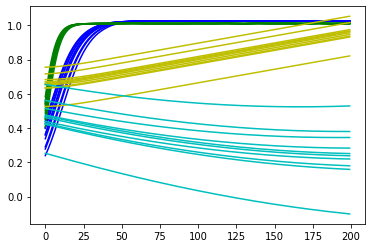

In [ ]:
mat = scipy.io.loadmat(main_path+'Data/truth40.mat')
x = torch.Tensor(mat['pred'][1:,:].reshape(200,40)).float()

plt.plot(x[:,0:10], 'b')
plt.plot(x[:,10:20], 'g')
plt.plot(x[:,20:30], 'y')
plt.plot(x[:,30:40], 'c')
plt.show()